# Loyal Health Data Science Coding Challenge

Instructions: The following questions are designed to assess your understanding of common data science concepts with which you should be familiar. We’ll have you complete some basic analysis over text reviews and their metadata from the popular music review site Pitchfork (https://pitchfork.com/). The data can be downloaded here (https://www.kaggle.com/nolanbconaway/pitchfork-data) in the form of a SQLite database.  We expect this to take around 2 hours (at most 3 hours) to complete. Although the completion of the assignment will not be strictly timed, please do not go over the allotted time. If time is an issue, focus the most on problems 2, 4, and 5. 

Write all of your code in this Jupyter notebook. When you’ve completed the assessment, please create a GitHub repository, and email us a link to this repository.


In [1]:
# Import here
import pandas as pd, numpy as np
pd.set_option("display.max_columns", 101)
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
from textblob import TextBlob
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Cursory Data Analysis:
a) Compute the number of albums belonging to each genre. You should notice that some albums have multiple genres listed (e.g. Folk/Country,Pop/R&B,Rock) separated by commas. Consider albums with multiple genres as belonging to each of those genres (i.e. an album with Rap,Rock as it’s genres will be counted as one Rap album and one Rock album). 

b) Compute the number of albums released each year.

c) Compute the ten artists with the highest number of albums reviewed in the data set.

d) Compute the mean, median, standard deviation, minimum, and maximum album scores. 

e) Compute the average score by each review author and return the result in a dataframe sort in descending order.

f) Compute the average album score per artist and return the result in a dataframe with an additional column for the number of albums they’ve had reviewed.
    i) Return the artists with the top 10 highest average scores
    ii) Return the artists with the top 10 lowest average scores


### Import Data

In [3]:
# let's import data first
conn = sql.connect('database.sqlite')
artists = pd.read_sql("select * from artists", conn)
content = pd.read_sql("select * from content", conn)
genres = pd.read_sql("select * from genres", conn)
labels = pd.read_sql("select * from labels", conn)
reviews = pd.read_sql("select * from reviews", conn)
years = pd.read_sql("select * from years", conn)

artists.shape, content.shape, genres.shape, labels.shape, reviews.shape, years.shape

((18831, 2), (18393, 2), (22680, 2), (20190, 2), (18393, 13), (19108, 2))

A quick look at data imported

#### artists data

In [4]:
artists.head()

,reviewid,artist
0,22703,massive attack
1,22721,krallice
2,22659,uranium club
3,22661,kleenex
4,22661,liliput


#### content data

In [5]:
content.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [6]:
content.iloc[2, 1]

'Minneapolis’ Uranium Club seem to revel in being aggressively obtuse. They sprung up last year with their Human Exploration EP, an eight-song tape of some of the most tightly-wound, gleefully mean, and well-constructed punk to grace the underground in a while. Human Exploration quickly became a must-have of the punk scene, receiving multiple vinyl pressings, all while the band rejected any web presence and most interviews as well.All of Them Naturals, their second EP, is Uranium Club indulging even more in such pranksterish qualities. The first two minutes of audio are pulled from the Nation of Ulysses handbook of sarcasm and myth-making, as a man with a vaguely British accent comments fictitiously on all the band has supposedly accomplished since its last record, from selling novelty pencils to distributing pamphlets for “pseudo-intellectual literature circles and swingers’ parties.” Uranium Club must know that people have been patiently waiting to hear more from them, and the final 

#### Genres data

In [7]:
genres.head()

,reviewid,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


In [8]:
genres['genre'].unique()

array(['electronic', 'metal', 'rock', None, 'rap', 'experimental',
       'pop/r&b', 'folk/country', 'jazz', 'global'], dtype=object)

I see dual genres such as 'pop/r&b', we might need to seperate them.

In [9]:
genres.query("reviewid.isin([22691, 22719])", engine='python')

,reviewid,genre
17,22719,rap
18,22719,pop/r&b
20,22691,rap
21,22691,pop/r&b


Seperate these multiple genre into each genre:

In [10]:
genres_sep = genres.assign(genre = lambda x: x['genre'].str.split('/')).explode('genre')
genres_sep.head()

,reviewid,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


In [11]:
genres_sep['genre'].unique()

array(['electronic', 'metal', 'rock', None, 'rap', 'experimental', 'pop',
       'r&b', 'folk', 'country', 'jazz', 'global'], dtype=object)

In [12]:
genres_sep.query("reviewid.isin([22691, 22719])", engine='python')

,reviewid,genre
17,22719,rap
18,22719,pop
18,22719,r&b
20,22691,rap
21,22691,pop
21,22691,r&b


All looking good!

#### labels data

In [13]:
labels.head()

,reviewid,label
0,22703,virgin
1,22721,hathenter
2,22659,static shock
3,22659,fashionable idiots
4,22661,kill rock stars


#### reviews data

In [14]:
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


#### years data

In [15]:
years.head()

,reviewid,year
0,22703,1998.0
1,22721,2016.0
2,22659,2016.0
3,22661,2016.0
4,22725,2016.0


> #### note: all tables are connected through `reviewid`

## a) Compute the number of albums belonging to each genre. You should notice that some albums have multiple genres listed (e.g. Folk/Country,Pop/R&B,Rock) separated by commas. Consider albums with multiple genres as belonging to each of those genres (i.e. an album with Rap,Rock as it’s genres will be counted as one Rap album and one Rock album). 

First, we need to remove the redundancy by merging reviews and genre_sep on 'reviewid' and only count the unique title of the album that belongs to each genre.

In [16]:
ans_a = reviews.merge(genres_sep, how='inner', on='reviewid'
             ).groupby(['genre'])['title'].nunique().to_frame('number_of_albums')

ans_a

,number_of_albums
genre,
country,683
electronic,3807
experimental,1796
folk,683
global,216
jazz,435
metal,856
pop,1425
r&b,1425


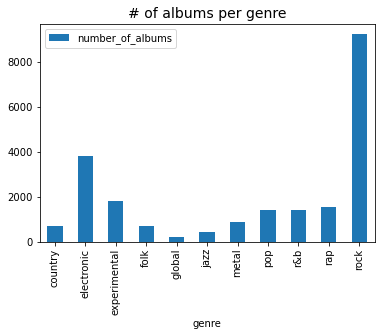

In [17]:
ax = ans_a.plot(kind='bar', figsize=(6, 4))
ax.set_title('# of albums per genre', fontsize=14);

## b) Compute the number of albums released each year.

For this task, we do not need to join tables because reviews have all information we need.

In [18]:
ans_b = reviews.groupby(['pub_year'])['title'].nunique().to_frame('number_of_albums')

# convert the year to int (it is float now)
ans_b.index = ans_b.index.astype(int)

ans_b

,number_of_albums
pub_year,
1999,223
2000,346
2001,455
2002,923
2003,1056
2004,1120
2005,1182
2006,1182
2007,1214


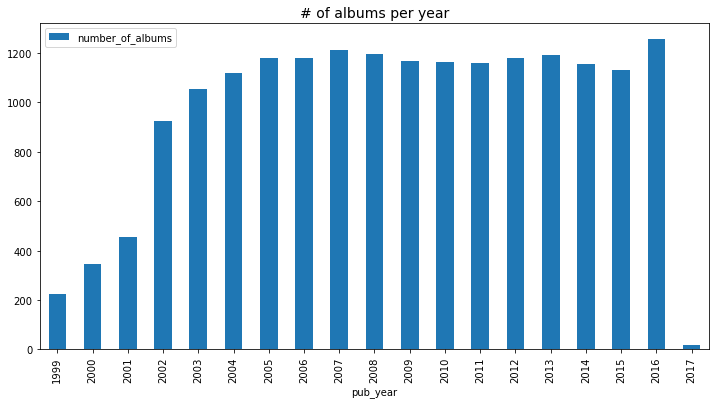

In [19]:
ax = ans_b.plot(kind='bar', figsize=(12, 6))
ax.set_title('# of albums per year', fontsize=14);

I see that majority of albums are from 2002 ~ 2016.

## c) Compute the ten artists with the highest number of albums reviewed in the data set.

In [20]:
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


`reviews` data contains all information we need - `artist` & `title`. With this information we can find the **ten artists with the highest number of albums that were reviewed** in the data set, not the artists with most reviews!

In [21]:
# Basically, we can safely assume albums in `reviews` dataframe are reviewed
# then question reduces to 'ten artists with the most albums'

ans_c = reviews.query('reviewid.notnull()', engine='python' # consider no reviewid, no reviews for that album
            ).groupby(['artist'])['title'].nunique(         # compute number of albums for an artist
            ).sort_values(ascending=False).to_frame('number_of_albums'
            ).head(10)  # get 10 top artists with most albums reviewed

ans_c

,number_of_albums
artist,
various artists,687
guided by voices,23
the beatles,21
david bowie,21
mogwai,20
of montreal,19
neil young,19
robert pollard,19
the fall,18


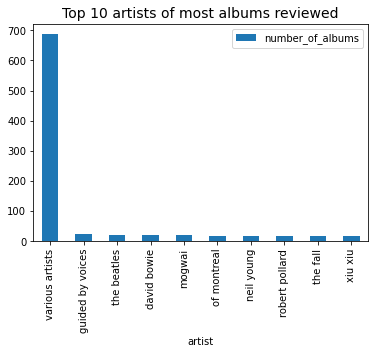

In [22]:
ax = ans_c.plot(kind='bar', figsize=(6, 4))
ax.set_title('Top 10 artists of most albums reviewed', fontsize=14);

Looks like various artists are congregation of multiple unknown artists. 
As a specific artist, looks like the Beatles and David Bowie are the top!

## d) Compute the mean, median, standard deviation, minimum, and maximum album scores.

We can use `describe()` to show descriptive statistisc for `score`

In [23]:
ans_d = reviews[['score']].describe().T
ans_d

,count,mean,std,min,25%,50%,75%,max
score,18393.0,7.005779,1.293675,0.0,6.4,7.2,7.8,10.0


- mean: 7.005779
- median: 7.20
- standard deviation: 1.293675
- minimum: 0.0
- maximum: 10.0

## e) Compute the average score by each review author and return the result in a dataframe sort in descending order.

In [24]:
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [25]:
# how many aruthor are there?
reviews['author'].nunique()

432

In [26]:
ans_e = reviews.groupby(['author'])['score'].mean(
            ).sort_values(ascending=False).to_frame('average_score')

ans_e

,average_score
author,
nelson george,10.000000
maura johnston,10.000000
carvell wallace,9.833333
dorian lynskey,9.500000
rollie pemberton & nick sylvester,9.400000
...,...
stephen m. deusner,3.800000
bob o. mcmillan,3.500000
dr. andy beta,3.300000


## f) Compute the average album score per artist and return the result in a dataframe with an additional column for the number of albums they’ve had reviewed. i) Return the artists with the top 10 highest average scores ii) Return the artists with the top 10 lowest average scores

In [27]:
ans_f = reviews.query('artist.notnull()', engine='python' # remove artist with no name or info
    ).groupby(['artist']).agg(
        average_album_score=('score', 'mean')   # average album score for each artist
        , number_of_albums=('title', 'nunique') # number of albums they have that are reviewed 
    ).sort_values(by=['average_album_score'], ascending=False) # sort data based on average album score in descending order

ans_f.head()

,average_album_score,number_of_albums
artist,,
the stone roses,10.0,1
stevie wonder,10.0,1
talk talk,10.0,1
dangelo,10.0,1
slint,10.0,1


#### i) Return the artists with the top 10 highest average scores

In [28]:
# show top 10 lines
ans_f.head(10)

,average_album_score,number_of_albums
artist,,
the stone roses,10.00,1
stevie wonder,10.00,1
talk talk,10.00,1
dangelo,10.00,1
slint,10.00,1
television,10.00,1
elvis costello & the attractions,9.75,2
ultramagnetic mc's,9.70,1
n.w.a.,9.70,1


#### ii) Return the artists with the top 10 lowest average scores

In [29]:
# show bottom 10 lines
ans_f.tail(10)

,average_album_score,number_of_albums
artist,,
"lou reed, metallica",1.0,1
non,1.0,2
geoff farina,1.0,1
"avey tare, kra brekkan",1.0,1
toe,0.8,1
liars academy,0.6,1
shat,0.2,1
dan le sac vs. scroobius pip,0.2,1
push kings,0.1,1


In [30]:
# remove above answers from memory
del ans_a
del ans_b
del ans_c
del ans_d
del ans_e
del ans_f

## 2) SQL:

Merge the database tables into a dataframe containing all of the relevant metadata.


In [31]:
df = reviews.merge(artists, on=['reviewid'], how='left', suffixes=['', '_y'] # artists is a subset of reviews, to keep 
        ).drop(columns=['artist_y']                                          # as much information, we use 'left' join
        ).merge(content, on='reviewid'
        ).merge(genres, on='reviewid'
        ).merge(labels, on='reviewid'
        ).merge(years, on='reviewid')

df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0


In [32]:
# ## if you want work using sql query:
# query = """select 
#                 *
#             from reviews
#             left join artists using (reviewid)
#             inner join content using (reviewid)
#             inner join genres using (reviewid)
#             inner join labels using (reviewid)
#             inner join years using (reviewid)"""

# df = pd.read_sql_query(query, conn)
# df.head()

In [33]:
df.shape

(27094, 17)

In [34]:
# remove individual data sets from memmory since we do not need henceforth.
del artists
del reviews
del content
del genres
del labels
del years

## 3) Dataframe Manipulation (Using the Dataframe from part 2) create new DataFrames based on the stipulations below):

a) Create a new DataFrame excluding all artists with names that start with the letter “M” (either upper or lowercase).

b) Create a new DataFrame excluding albums with a score less than 4.0.

c) Create a new DataFrame excluding albums from the label Columbia

d) Create a new DataFrame excluding albums that belong to the metal genre.

e) Create a new DataFrame excluding albums where that artist’s name contains an even number of characters (including whitespace as characters)

f) Combine these DataFrames into one where each album meets the conditions required for each.


## a) Create a new DataFrame excluding all artists with names that start with the letter “M” (either upper or lowercase).

In [35]:
df_a = df.query("~artist.str.contains('^m', case=False)", engine='python')
df_a.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0
5,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,mississippi,2016.0


In [36]:
df_a.shape

(25074, 17)

## b) Create a new DataFrame excluding albums with a score less than 4.0.


In [37]:
df_b = df.query("score >= 4.0")
df_b.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0


In [38]:
df_b.shape

(26210, 17)

## c) Create a new DataFrame excluding albums from the label Columbia

In [39]:
df_c = df.query("~label.str.contains('columbia', case=False, na=False)", engine='python')
df_c.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0


In [40]:
df_c.shape

(26824, 17)

## d) Create a new DataFrame excluding albums that belong to the metal genre.

In [41]:
df_d = df.query("~genre.str.contains('metal', case=False, na=False)", engine='python')
df_d.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0
5,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,mississippi,2016.0


In [42]:
df_d.shape

(26051, 17)

## e) Create a new DataFrame excluding albums where that artist’s name contains an even number of characters (including whitespace as characters)

In [43]:
# first strip whitespaces from left and right, then count letters in the artist name 
# including whitespace
df_e = df.assign(name_len = lambda x: x['artist'].str.strip().str.len() 
        ).query('name_len%2 == 1').drop(columns=['name_len'])
df_e.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
9,22722,insecure (music from the hbo original series),various artists,http://pitchfork.com/reviews/albums/22722-inse...,7.4,0,vanessa okoth-obbo,contributor,2017-01-05,3,5,1,2017,"In the pilot episode of “Insecure,” the critic...",None,rca,2016.0
10,22704,stillness in wonderland,little simz,http://pitchfork.com/reviews/albums/22704-litt...,7.1,0,katherine st. asaph,contributor,2017-01-05,3,5,1,2017,"Rapper Simbi Ajikawo, who records as Little Si...",rap,age 101,2016.0
12,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,4,1,2017,Ambient music is a funny thing. As innocuous a...,experimental,warp,2017.0
13,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,4,1,2017,There were innumerable cameos at the Bad Boy F...,rap,roc nation,2016.0
14,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,4,1,2017,Lots of drone musicians have been called sound...,experimental,important,2016.0


In [44]:
df_e.shape

(14367, 17)

## f) Combine these DataFrames into one where each album meets the conditions required for each.

In [45]:
df_q3 = df.query("~artist.str.contains('^m', case=False)", engine='python' # q3_a
            ).query("score >= 4.0" # q3_b
            ).query("~label.str.contains('columbia', case=False, na=False)", engine='python' # q3_c
            ).query("~genre.str.contains('metal', case=False, na=False)", engine='python' # q3_d
            ).assign(name_len = lambda x: x['artist'].str.strip().str.len() # q3_e
            ).query('name_len%2 == 1').drop(columns=['name_len'])

df_q3.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
9,22722,insecure (music from the hbo original series),various artists,http://pitchfork.com/reviews/albums/22722-inse...,7.4,0,vanessa okoth-obbo,contributor,2017-01-05,3,5,1,2017,"In the pilot episode of “Insecure,” the critic...",None,rca,2016.0
10,22704,stillness in wonderland,little simz,http://pitchfork.com/reviews/albums/22704-litt...,7.1,0,katherine st. asaph,contributor,2017-01-05,3,5,1,2017,"Rapper Simbi Ajikawo, who records as Little Si...",rap,age 101,2016.0
12,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,4,1,2017,Ambient music is a funny thing. As innocuous a...,experimental,warp,2017.0
13,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,4,1,2017,There were innumerable cameos at the Bad Boy F...,rap,roc nation,2016.0
14,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,4,1,2017,Lots of drone musicians have been called sound...,experimental,important,2016.0


In [46]:
df_q3.shape

(12349, 17)

In [47]:
# ## much slower way

# columns = df.columns.values.tolist()
# df_q3 = df_a.merge(df_b, on=columns).merge(df_c, on=columns).merge(df_d, on=columns).merge(df_e, on=columns)

# df_q3.head()

In [48]:
# remove answer dataframes above in this section
del df_a
del df_b
del df_c
del df_d
del df_e
del df_q3

## 4) Feature Engineering:

a) Construct a Pandas DataFrame (see problem 2) containing all album reviews and metadata. Remove any rows that have null values in any column.

b) Add a column to the dataframe for each genre. The entry in this column should be a 1 if the album/row in question belongs to that genre and 0 otherwise. Remember that albums can belong to multiple genres.

c) Add an additional two columns with categorical variables for 1) the author of the review and 2) the role of the author.

d) Create a column for the number of words in the review.

e) Create a column containing the sentiment score of the review. Treat the review as a single string and take the TextBlob polarity score (https://textblob.readthedocs.io/en/dev/quickstart.html).

> ## For more detailed analysis on features, please reference [this part](#Detailed-Analysis) in section 5-b) for Logistic Regression

## a) Construct a Pandas DataFrame (see problem 2) containing all album reviews and metadata. Remove any rows that have null values in any column.

In [49]:
df.isnull().sum()

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       5962
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
content              0
genre             2814
label               45
year               611
dtype: int64

In [50]:
df.shape

(27094, 17)

We see that `author_type`, `genre`, `label`, and `year` features (columns) contain null values

In [51]:
# drop any rows that have null values in any column
df.dropna(inplace=True)
df.isnull().sum()

reviewid          0
title             0
artist            0
url               0
score             0
best_new_music    0
author            0
author_type       0
pub_date          0
pub_weekday       0
pub_day           0
pub_month         0
pub_year          0
content           0
genre             0
label             0
year              0
dtype: int64

No missing values!

In [52]:
# reset index so it starts from 0 to len(df) - 1
df.reset_index(drop=True, inplace=True)
df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0


> From here onward, I will carry two dataframes - `df` and `df_original`. They are essentially same but `df_original` will not take hot-encoding measure (at least minimum degree); hence keeping the dataframe more compact. For later exploratory data analysis and feature engineering/selection, I will use `df_original`, and I will determine which dataframe to use for modeling and further analysis. 

In [53]:
# save df as df_original
df_original = df.copy(deep=True)

## b) Add a column to the dataframe for each genre. The entry in this column should be a 1 if the album/row in question belongs to that genre and 0 otherwise. Remember that albums can belong to multiple genres.

In [54]:
# from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_add = pd.DataFrame(data=mlb.fit_transform(df['genre'].str.split('/'))
                    , columns=['genre_'+ cl for cl in mlb.classes_])
df_add.head()

,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_r&b,genre_rap,genre_rock
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1


In [55]:
df = pd.concat([df, df_add], axis=1)
del df_add # no need anymore
df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_r&b,genre_rap,genre_rock
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,0,1,0,0,0,0,0,0,0,0,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,0,0,0,0,0,0,1,0,0,0,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,0,0,0,0,0,0,0,0,0,0,1
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0,0,0,0,0,0,0,0,0,0,0,1
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0,0,0,0,0,0,0,0,0,0,0,1


In [56]:
# rename 'r&b' to 'rnb' to prevent possible trouble later
df.rename(columns={'genre_r&b': 'genre_rnb'}, inplace=True)
df_original.rename(columns={'genre_r&b': 'genre_rnb'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18677 entries, 0 to 18676
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewid            18677 non-null  int64  
 1   title               18677 non-null  object 
 2   artist              18677 non-null  object 
 3   url                 18677 non-null  object 
 4   score               18677 non-null  float64
 5   best_new_music      18677 non-null  int64  
 6   author              18677 non-null  object 
 7   author_type         18677 non-null  object 
 8   pub_date            18677 non-null  object 
 9   pub_weekday         18677 non-null  int64  
 10  pub_day             18677 non-null  int64  
 11  pub_month           18677 non-null  int64  
 12  pub_year            18677 non-null  int64  
 13  content             18677 non-null  object 
 14  genre               18677 non-null  object 
 15  label               18677 non-null  object 
 16  year

In [57]:
## to check integrity
df.iloc[:, [0, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]].query(
    "genre.str.contains('/')", engine='python').tail(10)

,reviewid,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_rnb,genre_rap,genre_rock
18463,1638,pop/r&b,palm,2001.0,0,0,0,0,0,0,0,1,1,0,0
18473,701,folk/country,palace,2001.0,1,0,0,1,0,0,0,0,0,0,0
18494,106,pop/r&b,twisted nerve,2001.0,0,0,0,0,0,0,0,1,1,0,0
18495,5159,folk/country,domino,2000.0,1,0,0,1,0,0,0,0,0,0,0
18501,4776,pop/r&b,warp,2000.0,0,0,0,0,0,0,0,1,1,0,0
18521,1653,pop/r&b,instinct,2000.0,0,0,0,0,0,0,0,1,1,0,0
18527,729,pop/r&b,elektra,2000.0,0,0,0,0,0,0,0,1,1,0,0
18541,3581,pop/r&b,drag city,2000.0,0,0,0,0,0,0,0,1,1,0,0
18566,742,pop/r&b,jetset,2000.0,0,0,0,0,0,0,0,1,1,0,0
18616,699,folk/country,palace,1999.0,1,0,0,1,0,0,0,0,0,0,0


## c) Add an additional two columns with categorical variables for 1) the author of the review and 2) the role of the author.

In [58]:
# how many authors
print(df['author'].nunique())
df['author'].unique()

246


array(['nate patrin', 'zoe camp', 'david glickman', 'jenn pelly',
       'kevin lozano', 'katherine st. asaph', 'andy beta', 'ian cohen',
       'marc masters', 'sheldon pearce', 'thea ballard',
       'marcus j. moore', 'dean van nguyen', 'philip sherburne',
       'benjamin scheim', 'rebecca haithcoat', 'sam sodomsky',
       'seth colter walls', 'brian howe', 'marc hogan', 'quinn moreland',
       'seth colter-walls', 'savy reyes-kulkarni', 'renato pagnani',
       'matthew strauss', 'david turner', 'vanessa okoth-obbo',
       'matthew ramirez', 'jesse jarnow', 'andrew gaerig',
       'louis pattison', 'paul a. thompson', 'nathan reese',
       'ryan dombal', 'cameron cook', 'saby reyes-kulkarni',
       'mehan jayasuriya', 'ben scheim', 'stuart berman',
       'israel daramola', 'evan rytlewski', 'daniel martin-mccormick',
       'jay balfour', 'drew gaerig', 'mark richardson', 'paul thompson',
       'laura snapes', 'eric harvey', 'brad nelson', 'jonathan bernstein',
       'cary

In [59]:
# how many role of the author
print(df['author_type'].nunique())
df['author_type'].unique()

15


array(['contributor', 'associate reviews editor', 'tracks coordinator',
       'associate staff writer', 'contributing editor',
       'senior staff writer', 'assistant editor', 'associate editor',
       'senior editor', 'executive editor', 'associate features editor',
       'deputy news editor', 'managing editor', 'editor-in-chief',
       'news director'], dtype=object)

In [60]:
# add one-hot encoding for 'auothor' and 'author_type'
df = pd.concat([df, pd.get_dummies(df[['author', 'author_type']])], axis=1)
df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_rnb,genre_rap,genre_rock,author_aaron leitko,author_abby garnett,author_abigail covington,author_abigail garnett,author_adam moerder,author_allison hussey,author_amanda petrusich,author_amanda petrusich,author_amy granzin,author_amy phillips,author_andrew gaerig,author_andrew nosnitsky,author_andrew ryce,author_andy beta,author_andy emitt,author_andy o' connor,author_andy o'connor,author_angus finlayson,author_anupa mistry,author_b michael payne,author_b. david zarley,author_barry walters,...,author_sam lefebvre,author_sam sodomsky,author_samir khan,author_sarah sahim,author_sasha geffen,author_savy reyes-kulkarni,author_scott plagenhoef,author_sean fennessey,author_sean t. collins,author_seth colter walls,author_seth colter-walls,author_sheldon pearce,author_sheldon pearce,author_simon reynolds,author_stacey anderson,author_stephen m. deusner,author_stephen deusner,author_stephen m. deusner,author_stephen thomas erlewine,author_steven hyden,author_stuart berman,author_t. cole rachel,author_tal rosenberg,author_tayler montague,author_tess duncan,author_thea ballard,author_tim finney,author_tom breihan,author_tom ewing,author_vanessa okoth-obbo,author_vish khanna,author_william bowers,author_winston cook-wilson,author_zach kelly,author_zoe camp,author_type_assistant editor,author_type_associate editor,author_type_associate features editor,author_type_associate reviews editor,author_type_associate staff writer,author_type_contributing editor,author_type_contributor,author_type_deputy news editor,author_type_editor-in-chief,author_type_executive editor,author_type_managing editor,author_type_news director,author_type_senior editor,author_type_senior staff writer,author_type_tracks coordinator
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


We see that total of 261 (246+15) columns added. 

> Since now the data is very sparse, we might need to actually drop some category  one-hot encoded columns based on futher analysis. I will take further study at a later [section.](#Categorical-feature-engineering)

## d) Create a column for the number of words in the review.

In [61]:
df = df.assign(word_count = lambda x: x['content'].str.split().str.len())
df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_rnb,genre_rap,genre_rock,author_aaron leitko,author_abby garnett,author_abigail covington,author_abigail garnett,author_adam moerder,author_allison hussey,author_amanda petrusich,author_amanda petrusich,author_amy granzin,author_amy phillips,author_andrew gaerig,author_andrew nosnitsky,author_andrew ryce,author_andy beta,author_andy emitt,author_andy o' connor,author_andy o'connor,author_angus finlayson,author_anupa mistry,author_b michael payne,author_b. david zarley,author_barry walters,...,author_sam sodomsky,author_samir khan,author_sarah sahim,author_sasha geffen,author_savy reyes-kulkarni,author_scott plagenhoef,author_sean fennessey,author_sean t. collins,author_seth colter walls,author_seth colter-walls,author_sheldon pearce,author_sheldon pearce,author_simon reynolds,author_stacey anderson,author_stephen m. deusner,author_stephen deusner,author_stephen m. deusner,author_stephen thomas erlewine,author_steven hyden,author_stuart berman,author_t. cole rachel,author_tal rosenberg,author_tayler montague,author_tess duncan,author_thea ballard,author_tim finney,author_tom breihan,author_tom ewing,author_vanessa okoth-obbo,author_vish khanna,author_william bowers,author_winston cook-wilson,author_zach kelly,author_zoe camp,author_type_assistant editor,author_type_associate editor,author_type_associate features editor,author_type_associate reviews editor,author_type_associate staff writer,author_type_contributing editor,author_type_contributor,author_type_deputy news editor,author_type_editor-in-chief,author_type_executive editor,author_type_managing editor,author_type_news director,author_type_senior editor,author_type_senior staff writer,author_type_tracks coordinator,word_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1456
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,419
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,597
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,597
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1240


## e) Create a column containing the sentiment score of the review. Treat the review as a single string and take the TextBlob polarity score 

In [62]:
# from textblob import TextBlob
df = df.assign(sentiment_score = lambda x: x['content'].apply(lambda y: TextBlob(y).sentiment.polarity))
df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_rnb,genre_rap,genre_rock,author_aaron leitko,author_abby garnett,author_abigail covington,author_abigail garnett,author_adam moerder,author_allison hussey,author_amanda petrusich,author_amanda petrusich,author_amy granzin,author_amy phillips,author_andrew gaerig,author_andrew nosnitsky,author_andrew ryce,author_andy beta,author_andy emitt,author_andy o' connor,author_andy o'connor,author_angus finlayson,author_anupa mistry,author_b michael payne,author_b. david zarley,author_barry walters,...,author_samir khan,author_sarah sahim,author_sasha geffen,author_savy reyes-kulkarni,author_scott plagenhoef,author_sean fennessey,author_sean t. collins,author_seth colter walls,author_seth colter-walls,author_sheldon pearce,author_sheldon pearce,author_simon reynolds,author_stacey anderson,author_stephen m. deusner,author_stephen deusner,author_stephen m. deusner,author_stephen thomas erlewine,author_steven hyden,author_stuart berman,author_t. cole rachel,author_tal rosenberg,author_tayler montague,author_tess duncan,author_thea ballard,author_tim finney,author_tom breihan,author_tom ewing,author_vanessa okoth-obbo,author_vish khanna,author_william bowers,author_winston cook-wilson,author_zach kelly,author_zoe camp,author_type_assistant editor,author_type_associate editor,author_type_associate features editor,author_type_associate reviews editor,author_type_associate staff writer,author_type_contributing editor,author_type_contributor,author_type_deputy news editor,author_type_editor-in-chief,author_type_executive editor,author_type_managing editor,author_type_news director,author_type_senior editor,author_type_senior staff writer,author_type_tracks coordinator,word_count,sentiment_score
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1456,0.097281
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,419,0.041640
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,597,0.123304
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,597,0.123304
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1240,0.161576


In [63]:
# keep updating df_original as well
df_original = df[df_original.columns.tolist()+['word_count', 'sentiment_score']].copy(deep=True)

## 5) Logistic Regression: 

You will now use the features you constructed in the previous exercise to complete a binary logistic regression task accounting for whether an album reviews Pitchfork’s designation of “Best New Music.” This is represented by the binary “bnm” variable in the dataset. 

a) Scale all non-categorical variables as needed.

b) Perform your logistic regression model using the statsmodel library (https://www.pythonfordatascience.org/logistic-regression-python/ ). Treat the best new music variable as your dependent variable and use the release year, word count, sentiment, all genre binary variables, author, and author role as your independent variables. 

c) Calculate the odds ratios for your independent variables

d) What features are most/least predictive of a best new music designation and why do you think that is?

e) If you were to engineer an additional feature for the regression, what would it be? Describe how you would approach constructing that feature.


## a) Scale all non-categorical variables as needed.

Numerical features that possibly needs scaling are 'score', 'word_count', 'sentiment_score'

In [64]:
# a quick look at where we are with data
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18677 entries, 0 to 18676
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviewid         18677 non-null  int64  
 1   title            18677 non-null  object 
 2   artist           18677 non-null  object 
 3   url              18677 non-null  object 
 4   score            18677 non-null  float64
 5   best_new_music   18677 non-null  int64  
 6   author           18677 non-null  object 
 7   author_type      18677 non-null  object 
 8   pub_date         18677 non-null  object 
 9   pub_weekday      18677 non-null  int64  
 10  pub_day          18677 non-null  int64  
 11  pub_month        18677 non-null  int64  
 12  pub_year         18677 non-null  int64  
 13  content          18677 non-null  object 
 14  genre            18677 non-null  object 
 15  label            18677 non-null  object 
 16  year             18677 non-null  float64
 17  word_count  

> Recall, I am still carrying two dataframes - `df` and `df_original`

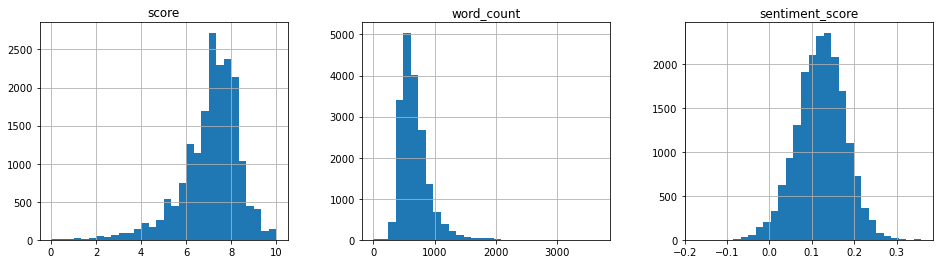

In [65]:
# deifne numerical columns
num_cols = ['score', 'word_count', 'sentiment_score']
# plot the distributions for numerical variables before normalization
df.hist(num_cols, bins=30, layout=(1,3), figsize=(16, 4));

`score` is left-skewed, `word_count` is right_skewed, and `sentiment_score` looks normally distributed. 
You can simply use `StandardScaler` but I will use `RobustScaler` which is more robust against outliers. 
The difference between them is `RobustScaler` uses median intead of mean.

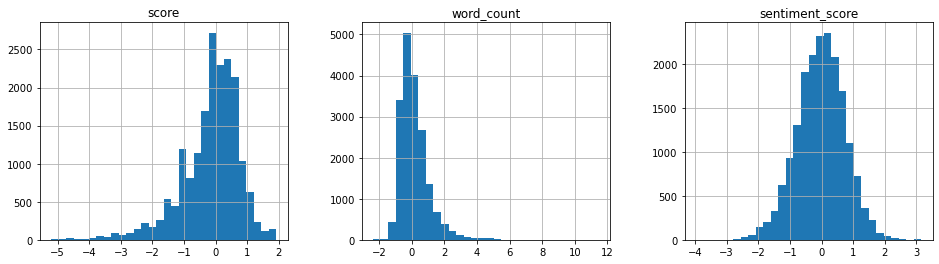

In [66]:
# from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df_original[num_cols] = scaler.transform(df_original[num_cols])

df.hist(num_cols, bins=30, layout=(1,3), figsize=(16, 4));

Now `score`, `word_count`, and `sentiment_score` are scaled.

## b) Perform your logistic regression model using the statsmodel library. Treat the best new music variable as your dependent variable and use the release year, word count, sentiment, all genre binary variables, author, and author role as your independent variables.

In [67]:
# rename target according to the instruction
df.rename(columns={'best_new_music': 'bnm'}, inplace=True)
df_original.rename(columns={'best_new_music': 'bnm'}, inplace=True)

# remove duplicates so we don't unnecessarily weight certain records
df.drop_duplicates(inplace=True)
df_original.drop_duplicates(inplace=True)
# make sure to reset index
df_original.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(17811, 291)


,reviewid,title,artist,url,score,bnm,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,genre_country,genre_electronic,genre_experimental,genre_folk,genre_global,genre_jazz,genre_metal,genre_pop,genre_rnb,genre_rap,genre_rock,author_aaron leitko,author_abby garnett,author_abigail covington,author_abigail garnett,author_adam moerder,author_allison hussey,author_amanda petrusich,author_amanda petrusich,author_amy granzin,author_amy phillips,author_andrew gaerig,author_andrew nosnitsky,author_andrew ryce,author_andy beta,author_andy emitt,author_andy o' connor,author_andy o'connor,author_angus finlayson,author_anupa mistry,author_b michael payne,author_b. david zarley,author_barry walters,...,author_samir khan,author_sarah sahim,author_sasha geffen,author_savy reyes-kulkarni,author_scott plagenhoef,author_sean fennessey,author_sean t. collins,author_seth colter walls,author_seth colter-walls,author_sheldon pearce,author_sheldon pearce,author_simon reynolds,author_stacey anderson,author_stephen m. deusner,author_stephen deusner,author_stephen m. deusner,author_stephen thomas erlewine,author_steven hyden,author_stuart berman,author_t. cole rachel,author_tal rosenberg,author_tayler montague,author_tess duncan,author_thea ballard,author_tim finney,author_tom breihan,author_tom ewing,author_vanessa okoth-obbo,author_vish khanna,author_william bowers,author_winston cook-wilson,author_zach kelly,author_zoe camp,author_type_assistant editor,author_type_associate editor,author_type_associate features editor,author_type_associate reviews editor,author_type_associate staff writer,author_type_contributing editor,author_type_contributor,author_type_deputy news editor,author_type_editor-in-chief,author_type_executive editor,author_type_managing editor,author_type_news director,author_type_senior editor,author_type_senior staff writer,author_type_tracks coordinator,word_count,sentiment_score
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,1.428571,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.112360,-0.344656
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,0.428571,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.771536,-1.090860
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,0.000000,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.104869,0.004339
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,0.000000,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.104869,0.004339
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,1.214286,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,2016.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.303371,0.517602


---------
## Detailed Analysis
Before I jump into modeling, I will study the data a little more.

### Defining the problem statement

create a Logitic Regression model to classify best new music correctly.

### Identifying the Target Variable
- Target variable: 'bnm'
- Indepent Variables: author_type, pub_year, 'sentiment_score', 'word_count', etc

> At this point, I realize that we do not need `df` dataframe for futher analysis and modeling because `statsmodels` have ability to take categorical values as is with a little trick - using C(categorical feature). Therefore, I will release it from memory.

In [68]:
# remove df, we will use only df_original from here
del df

In [69]:
target = 'bnm'
features = df_original.columns.drop(target).tolist()

### Looking at the distribution of Target variable 

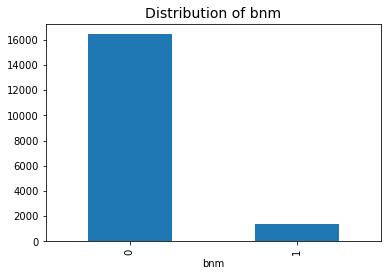

In [70]:
ax = df_original.groupby(target).size().plot.bar(figsize=(6, 4))
ax.set_title(f"Distribution of {target}", fontsize=14);

We see that target class is imbalanced. However, for the sake of purpose of this project, I will not take any measure to ameliorate imbalance situation. 

### Basic Exploratory Data Analysis (EDA)
This step is performed to gauge the data - the volume of data and types of columns present in the data. I will reject unnecessary columns based on this analysis and check if some features needs treatment.

In [71]:
df_original.head(3)

,reviewid,title,artist,url,score,bnm,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,word_count,sentiment_score
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,1.428571,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,1998.0,3.112360,-0.344656
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,0.428571,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,2016.0,-0.771536,-1.090860
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,0.000000,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,2016.0,-0.104869,0.004339


In [72]:
## check data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17811 entries, 0 to 17810
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviewid         17811 non-null  int64  
 1   title            17811 non-null  object 
 2   artist           17811 non-null  object 
 3   url              17811 non-null  object 
 4   score            17811 non-null  float64
 5   bnm              17811 non-null  int64  
 6   author           17811 non-null  object 
 7   author_type      17811 non-null  object 
 8   pub_date         17811 non-null  object 
 9   pub_weekday      17811 non-null  int64  
 10  pub_day          17811 non-null  int64  
 11  pub_month        17811 non-null  int64  
 12  pub_year         17811 non-null  int64  
 13  content          17811 non-null  object 
 14  genre            17811 non-null  object 
 15  label            17811 non-null  object 
 16  year             17811 non-null  float64
 17  word_count  

### Quick check on suspicious case

In [73]:
df_original[['pub_date', 'pub_day', 'pub_month', 'pub_year', 'year']].corr()

,pub_day,pub_month,pub_year,year
pub_day,1.000000,-0.082569,-0.020559,0.001168
pub_month,-0.082569,1.000000,-0.032123,-0.010981
pub_year,-0.020559,-0.032123,1.000000,0.589505
year,0.001168,-0.010981,0.589505,1.000000


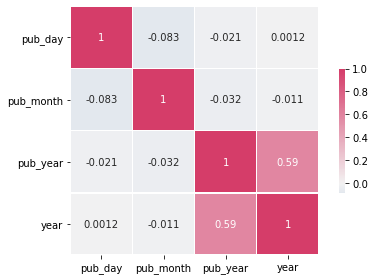

In [74]:
cmap = sns.diverging_palette(250, 0, as_cmap=True)
sns.heatmap(df_original[['pub_date', 'pub_day', 'pub_month', 'pub_year', 'year']].corr()
           , cmap=cmap, center=0, annot=True, square=True, linewidths=.5, cbar_kws={'shrink':.5})
plt.tight_layout()

Looks like `pub_year` and `year` are highly correlated. We can safely drop `year` for the sake of simplicity.

Also, it looks like some features are not using correct data types. Let's fix it.

In [75]:
df_original = df_original.assign(reviewid = lambda x: x['reviewid'].astype('str')
                    ).assign(pub_date = lambda x: pd.to_datetime(x['pub_date'])
                    ).assign(pub_weekday = lambda x: x['pub_weekday'].astype('category')
                    ).assign(pub_day = lambda x: x['pub_day'].astype('category')
                    ).assign(pub_month = lambda x: x['pub_month'].astype('category')
                    ).assign(pub_year = lambda x: x['pub_year'].astype('category')
                    ).assign(year = lambda x: x['year'].astype('category'))

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17811 entries, 0 to 17810
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reviewid         17811 non-null  object        
 1   title            17811 non-null  object        
 2   artist           17811 non-null  object        
 3   url              17811 non-null  object        
 4   score            17811 non-null  float64       
 5   bnm              17811 non-null  int64         
 6   author           17811 non-null  object        
 7   author_type      17811 non-null  object        
 8   pub_date         17811 non-null  datetime64[ns]
 9   pub_weekday      17811 non-null  category      
 10  pub_day          17811 non-null  category      
 11  pub_month        17811 non-null  category      
 12  pub_year         17811 non-null  category      
 13  content          17811 non-null  object        
 14  genre            17811 non-null  objec

In [76]:
# Descriptive statistics of the data
df_original.describe(include='all', datetime_is_numeric=False)

,reviewid,title,artist,url,score,bnm,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre,label,year,word_count,sentiment_score
count,17811,17811,17811,17811,17811.000000,17811.000000,17811,17811,17811,17811.0,17811.0,17811.0,17811.0,17811,17811,17811,17811.0,17811.000000,17811.000000
unique,12350,12033,6174,12350,NaN,NaN,246,15,3715,7.0,31.0,12.0,19.0,12345,9,2782,57.0,NaN,NaN
top,19835,dj-kicks,the beatles,http://pitchfork.com/reviews/albums/19835-a-ce...,NaN,NaN,joe tangari,contributor,2014-11-03 00:00:00,1.0,7.0,4.0,2011.0,Manchester's post-punk music scene in the earl...,rock,self-released,2011.0,NaN,NaN
freq,12,19,34,12,NaN,NaN,927,15180,18,3684.0,664.0,1742.0,1533.0,12,8195,397,1487.0,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-02-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,-0.162953,0.078098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.191172,-0.025165
std,NaN,NaN,NaN,NaN,0.923940,0.268333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955435,0.760625
min,NaN,NaN,NaN,NaN,-5.214286,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.340824,-3.977614
25%,NaN,NaN,NaN,NaN,-0.571429,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.430712,-0.515277


Some categorical columns (features) are too diverse to a degree that it's almost unique to all rows. These features are typically advised to not use it.

### Basic EDA result

- `reviewid`: unique to almost all rows. **rejected**
- `title`: unique to almost all rows. **rejected**
- `artist`: highly diverse. **rejected**
- `url`: unique to almost all rows. **rejected**
- `score`: numerical. **selected**
- `author`: highly diverse. **selected** conditionally. 
- `author_type`: categorical. **selected**
- `pub_date`: datetime. Its information is stored through other variables such as 'pub_day', 'pub_month'. **rejected**
- `pub_weekday`: categorical. **selected**
- `pub_day`: categorical. **select**
- `pub_month`: categorical. **selected**
- `pub_year`: categorical. **selected**
- `content`: unique to almost all rows. **rejected**
- `genre`: categorical. **selected**
- `label`: highly diverse. **rejected**
- `year`: highly correlated to 'pub_year'. **rejected**
- `word_count`: numerical. **selected**
- `sentiment_score`: numerical. **selected**

### Removing useless variables

In [77]:
df_original.drop(columns=['reviewid', 'title', 'artist', 'url', 'pub_date', 'content', 'label', 'year'], inplace=True)
df_original.head()

,score,bnm,author,author_type,pub_weekday,pub_day,pub_month,pub_year,genre,word_count,sentiment_score
0,1.428571,0,nate patrin,contributor,6,8,1,2017,electronic,3.112360,-0.344656
1,0.428571,0,zoe camp,contributor,5,7,1,2017,metal,-0.771536,-1.090860
2,0.000000,0,david glickman,contributor,5,7,1,2017,rock,-0.104869,0.004339
3,0.000000,0,david glickman,contributor,5,7,1,2017,rock,-0.104869,0.004339
4,1.214286,1,jenn pelly,associate reviews editor,4,6,1,2017,rock,2.303371,0.517602


In [78]:
# categorical columns
cat_cols = df_original.select_dtypes(exclude=['number']).columns.tolist()
num_cols = ['score', 'word_count', 'sentiment_score']
target, cat_cols, num_cols

('bnm',
 ['author',
  'author_type',
  'pub_weekday',
  'pub_day',
  'pub_month',
  'pub_year',
  'genre'],
 ['score', 'word_count', 'sentiment_score'])

In [79]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17811 entries, 0 to 17810
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   score            17811 non-null  float64 
 1   bnm              17811 non-null  int64   
 2   author           17811 non-null  object  
 3   author_type      17811 non-null  object  
 4   pub_weekday      17811 non-null  category
 5   pub_day          17811 non-null  category
 6   pub_month        17811 non-null  category
 7   pub_year         17811 non-null  category
 8   genre            17811 non-null  object  
 9   word_count       17811 non-null  float64 
 10  sentiment_score  17811 non-null  float64 
dtypes: category(4), float64(3), int64(1), object(3)
memory usage: 1.0+ MB


### Visual EDA
#### Check Feature Distribution

#### 1) Categorical

In [80]:
def plot_bar_charts(data, cols_to_plot, ncols=4, figsize=(12, 4)):
    """
    Explore distributions of categorical features
    """
    # just in case
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    # Generating multiple subplots
    if len(cols_to_plot) > ncols:
        fig, subplot = plt.subplots(nrows=(len(cols_to_plot)-1)//ncols+1, ncols=ncols, figsize=figsize)
        fig.suptitle('Bar Charts of: ' + str(cols_to_plot), fontsize=14, y=1.005)

        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            data.groupby([col_name]).size().plot(kind='bar', ax=subplot[plot_number//ncols][plot_number%ncols])
    else:
        fig, subplot = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
        fig.suptitle('Bar Charts of: ' + str(cols_to_plot), fontsize=14)

        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            data.groupby([col_name]).size().plot(kind='bar', ax=subplot[plot_number])
        
    plt.tight_layout();

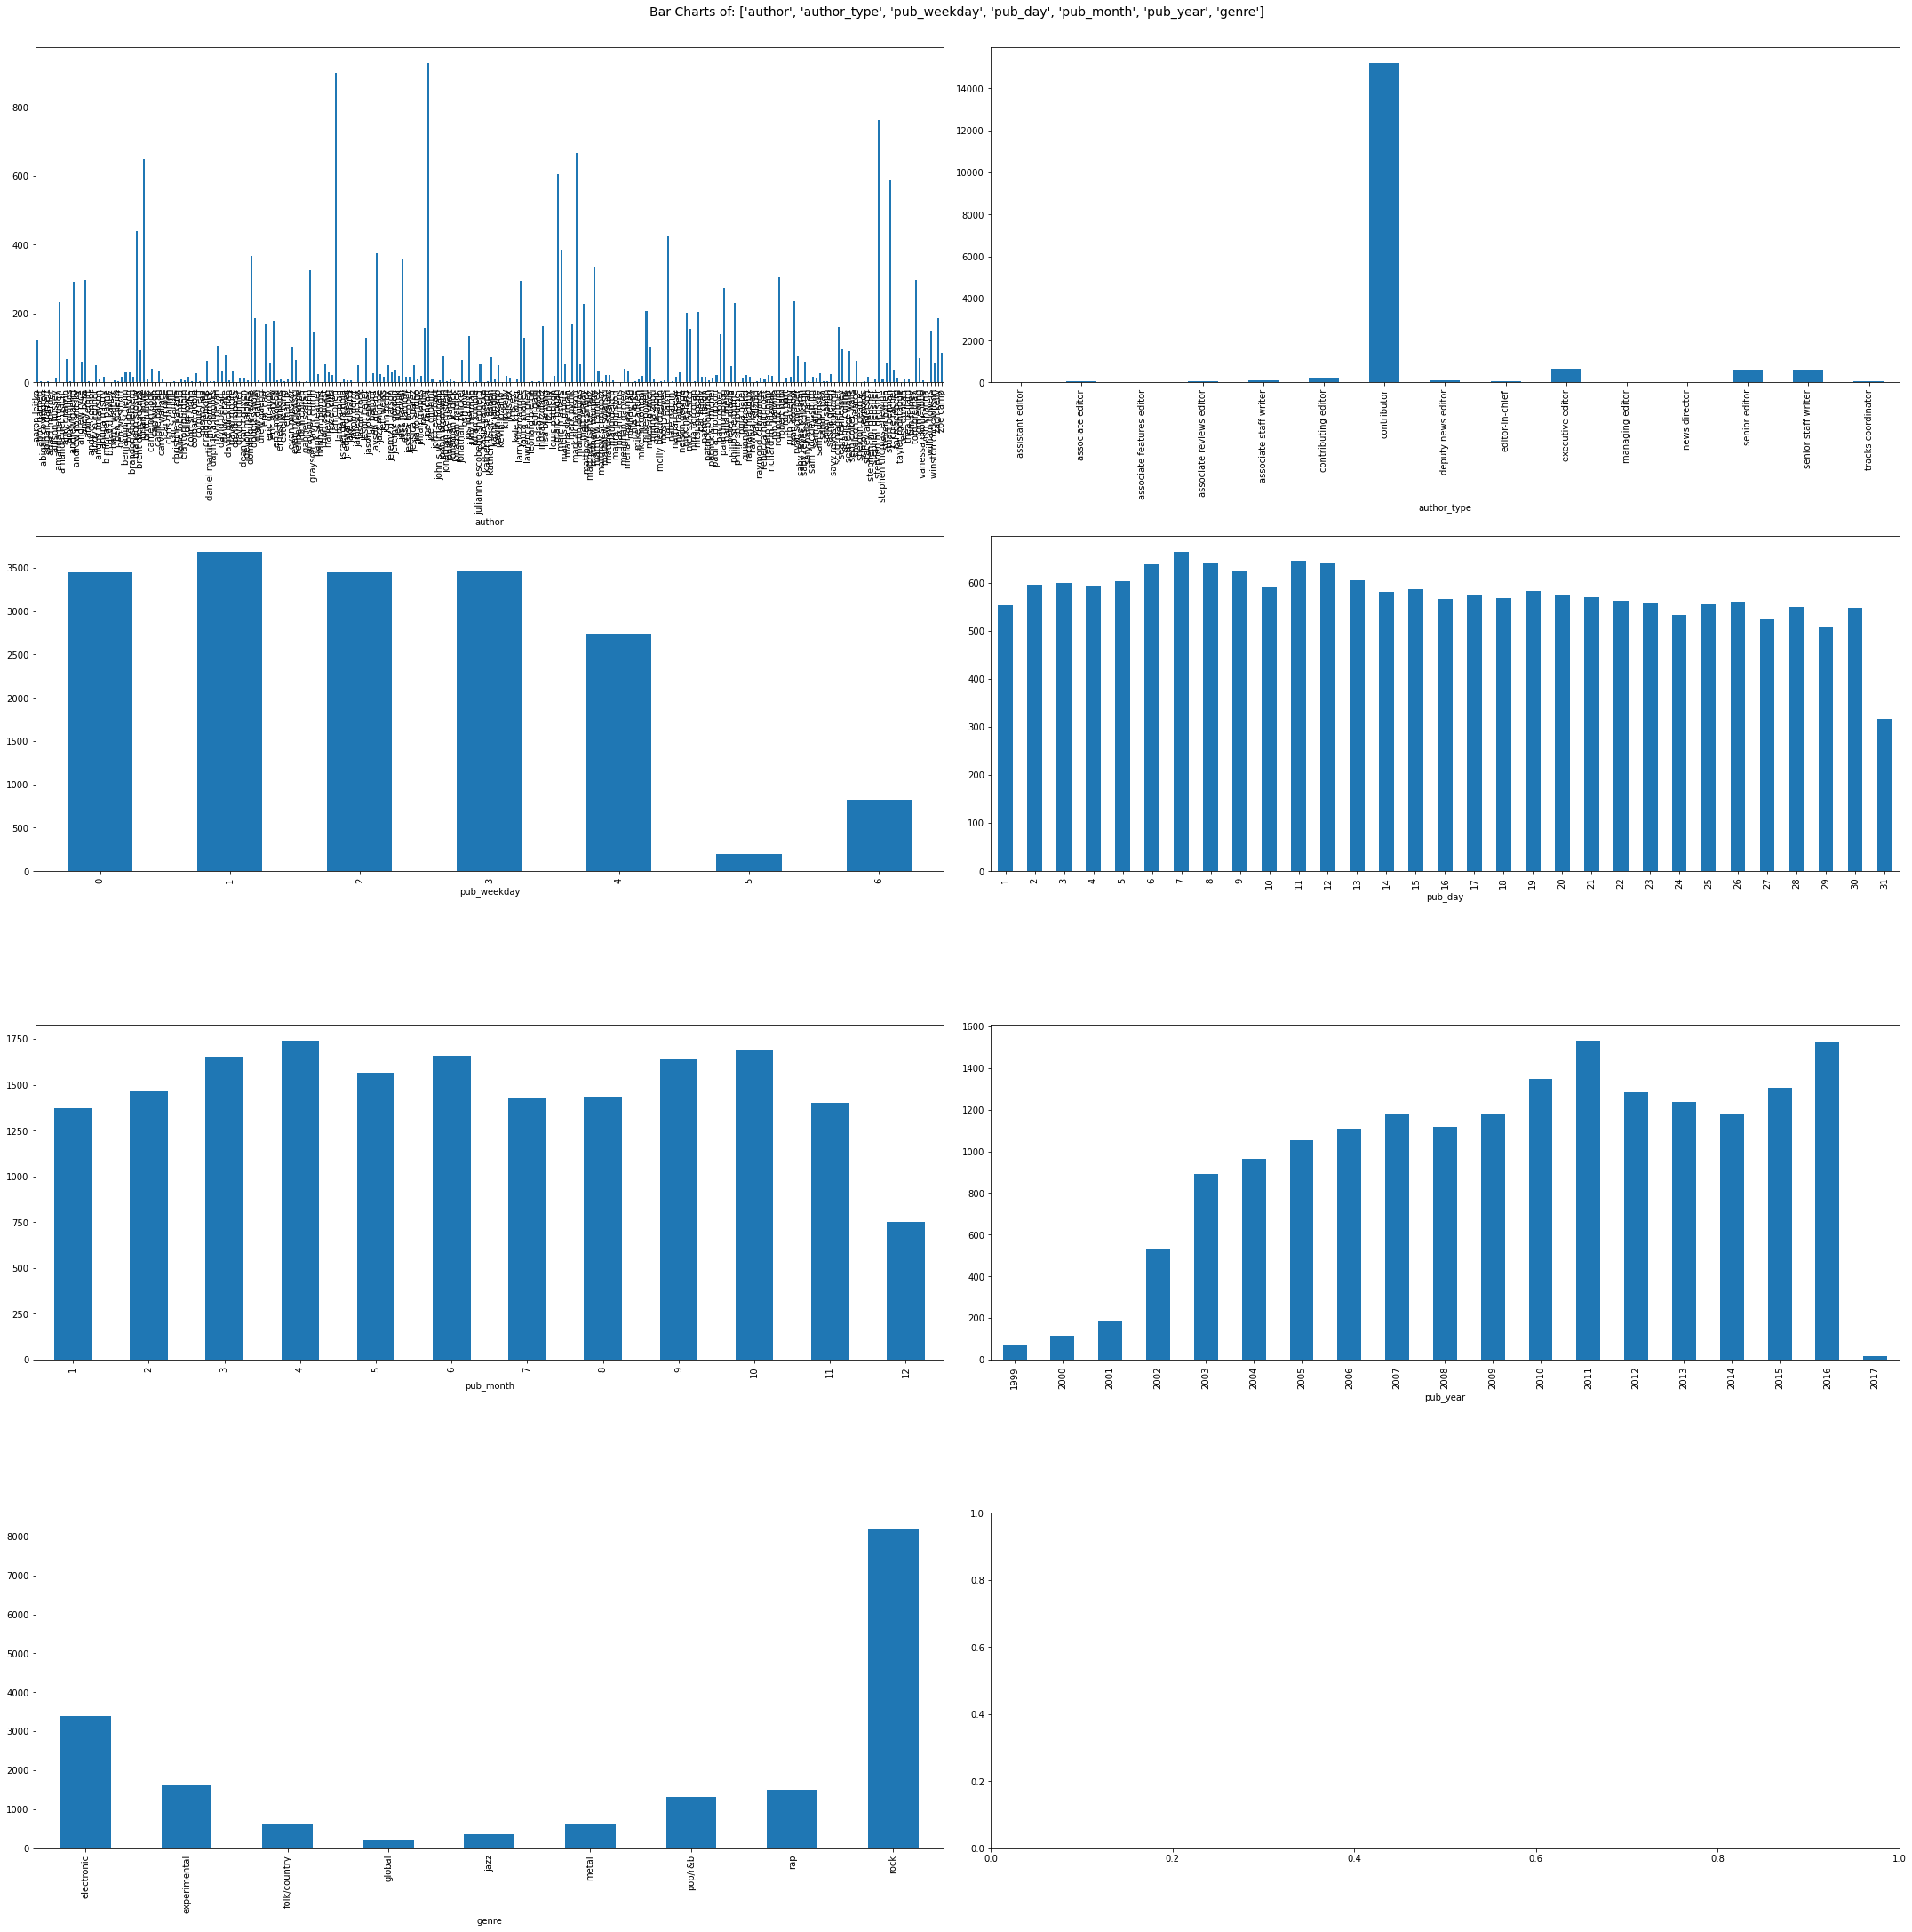

In [81]:
plot_bar_charts(df_original, cat_cols, ncols=2, figsize=(30, 30))

In the ideal bar chart each category has comparable frequency. Hence, there are enough rows for each category in the data for the ML algorithm to learn.

If there is a column which shows too skewed distribution where there is only one dominant bar and the other categories are present in very low numbers. These kind of columns may not be very helpful in machine learning. We confirm this in the correlation analysis section and take a final call to select or reject the column.

#### Categorical feature engineering
As of now, I'd like to work on 2 features: 
- `author`: Too many authors and some authors apparently review more than the others --> simplify based on # of review
- `author_type`: Contributor as a role of author is too dominant --> Contributor vs. Non-Contributor

##### `author`

,count,mean,std,min,10%,20%,25%,50%,75%,80%,85%,90%,95%,99%,max
number_of_review,246.0,72.402439,144.736004,1.0,1.0,2.0,3.0,15.0,60.75,91.0,152.0,218.0,354.0,720.25,927.0


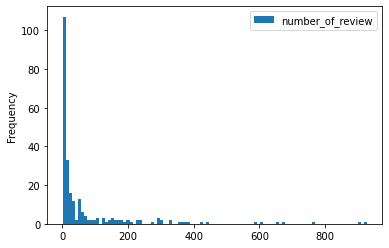

In [82]:
tmp = df_original.groupby('author').size().to_frame('number_of_review')
# display distribution of number of reviews per author
tmp.plot(kind='hist', bins=100, figsize=(6, 4));
tmp.describe([.1, .2, .25, .5, .75, .8, .85, .9, .95, .99]).T

We can observe that it is highly right-skewed and 50% of data reside below 15 and 75% below 60.75, and 80% below 91.
Since unnecessarily diversifying category reduces feature's predicting power and leads to sparce data (curse of dimensionality), let us set two thresholds at 85% percentil value (152.00) and 95% percentile value (354.00). Authors with number of reviews below the lower threshold are set to 'small', authors with number of reviews above the higher threshold are set to 'big', and the other authors are set to 'medium'

In [83]:
l_threshold, h_threshold = 152, 354
big_authors = tmp.query('number_of_review > @h_threshold').index.tolist()
medium_authors = tmp.query('@l_threshold < number_of_review <= @h_threshold').index.tolist()
small_authors = tmp.query('number_of_review <= @l_threshold').index.tolist()

# big_authors

In [84]:
# Does each bin have enough data for learning, better yet similar size?
print(df_original.loc[df_original['author'].isin(big_authors), 'author'].shape[0])
print(df_original.loc[df_original['author'].isin(medium_authors), 'author'].shape[0])
print(df_original.loc[df_original['author'].isin(small_authors), 'author'].shape[0])

7451
5498
4862


In [85]:
# simplify 'author' feature
df_original.loc[df_original['author'].isin(big_authors), 'author'] = 'big'
df_original.loc[df_original['author'].isin(medium_authors), 'author'] = 'medium'
df_original.loc[df_original['author'].isin(small_authors), 'author'] = 'small'

##### `author_type`

In [86]:
# convert Non-contributor to 'no contributor'
df_original = df_original.assign(author_type = lambda x: x['author_type'].astype('str'))
df_original.loc[df_original['author_type'] != 'contributor', 'author_type'] = 'no contributor'
# bring back to category data type
df_original = df_original.assign(author_type = lambda x: x['author_type'].astype('category'))

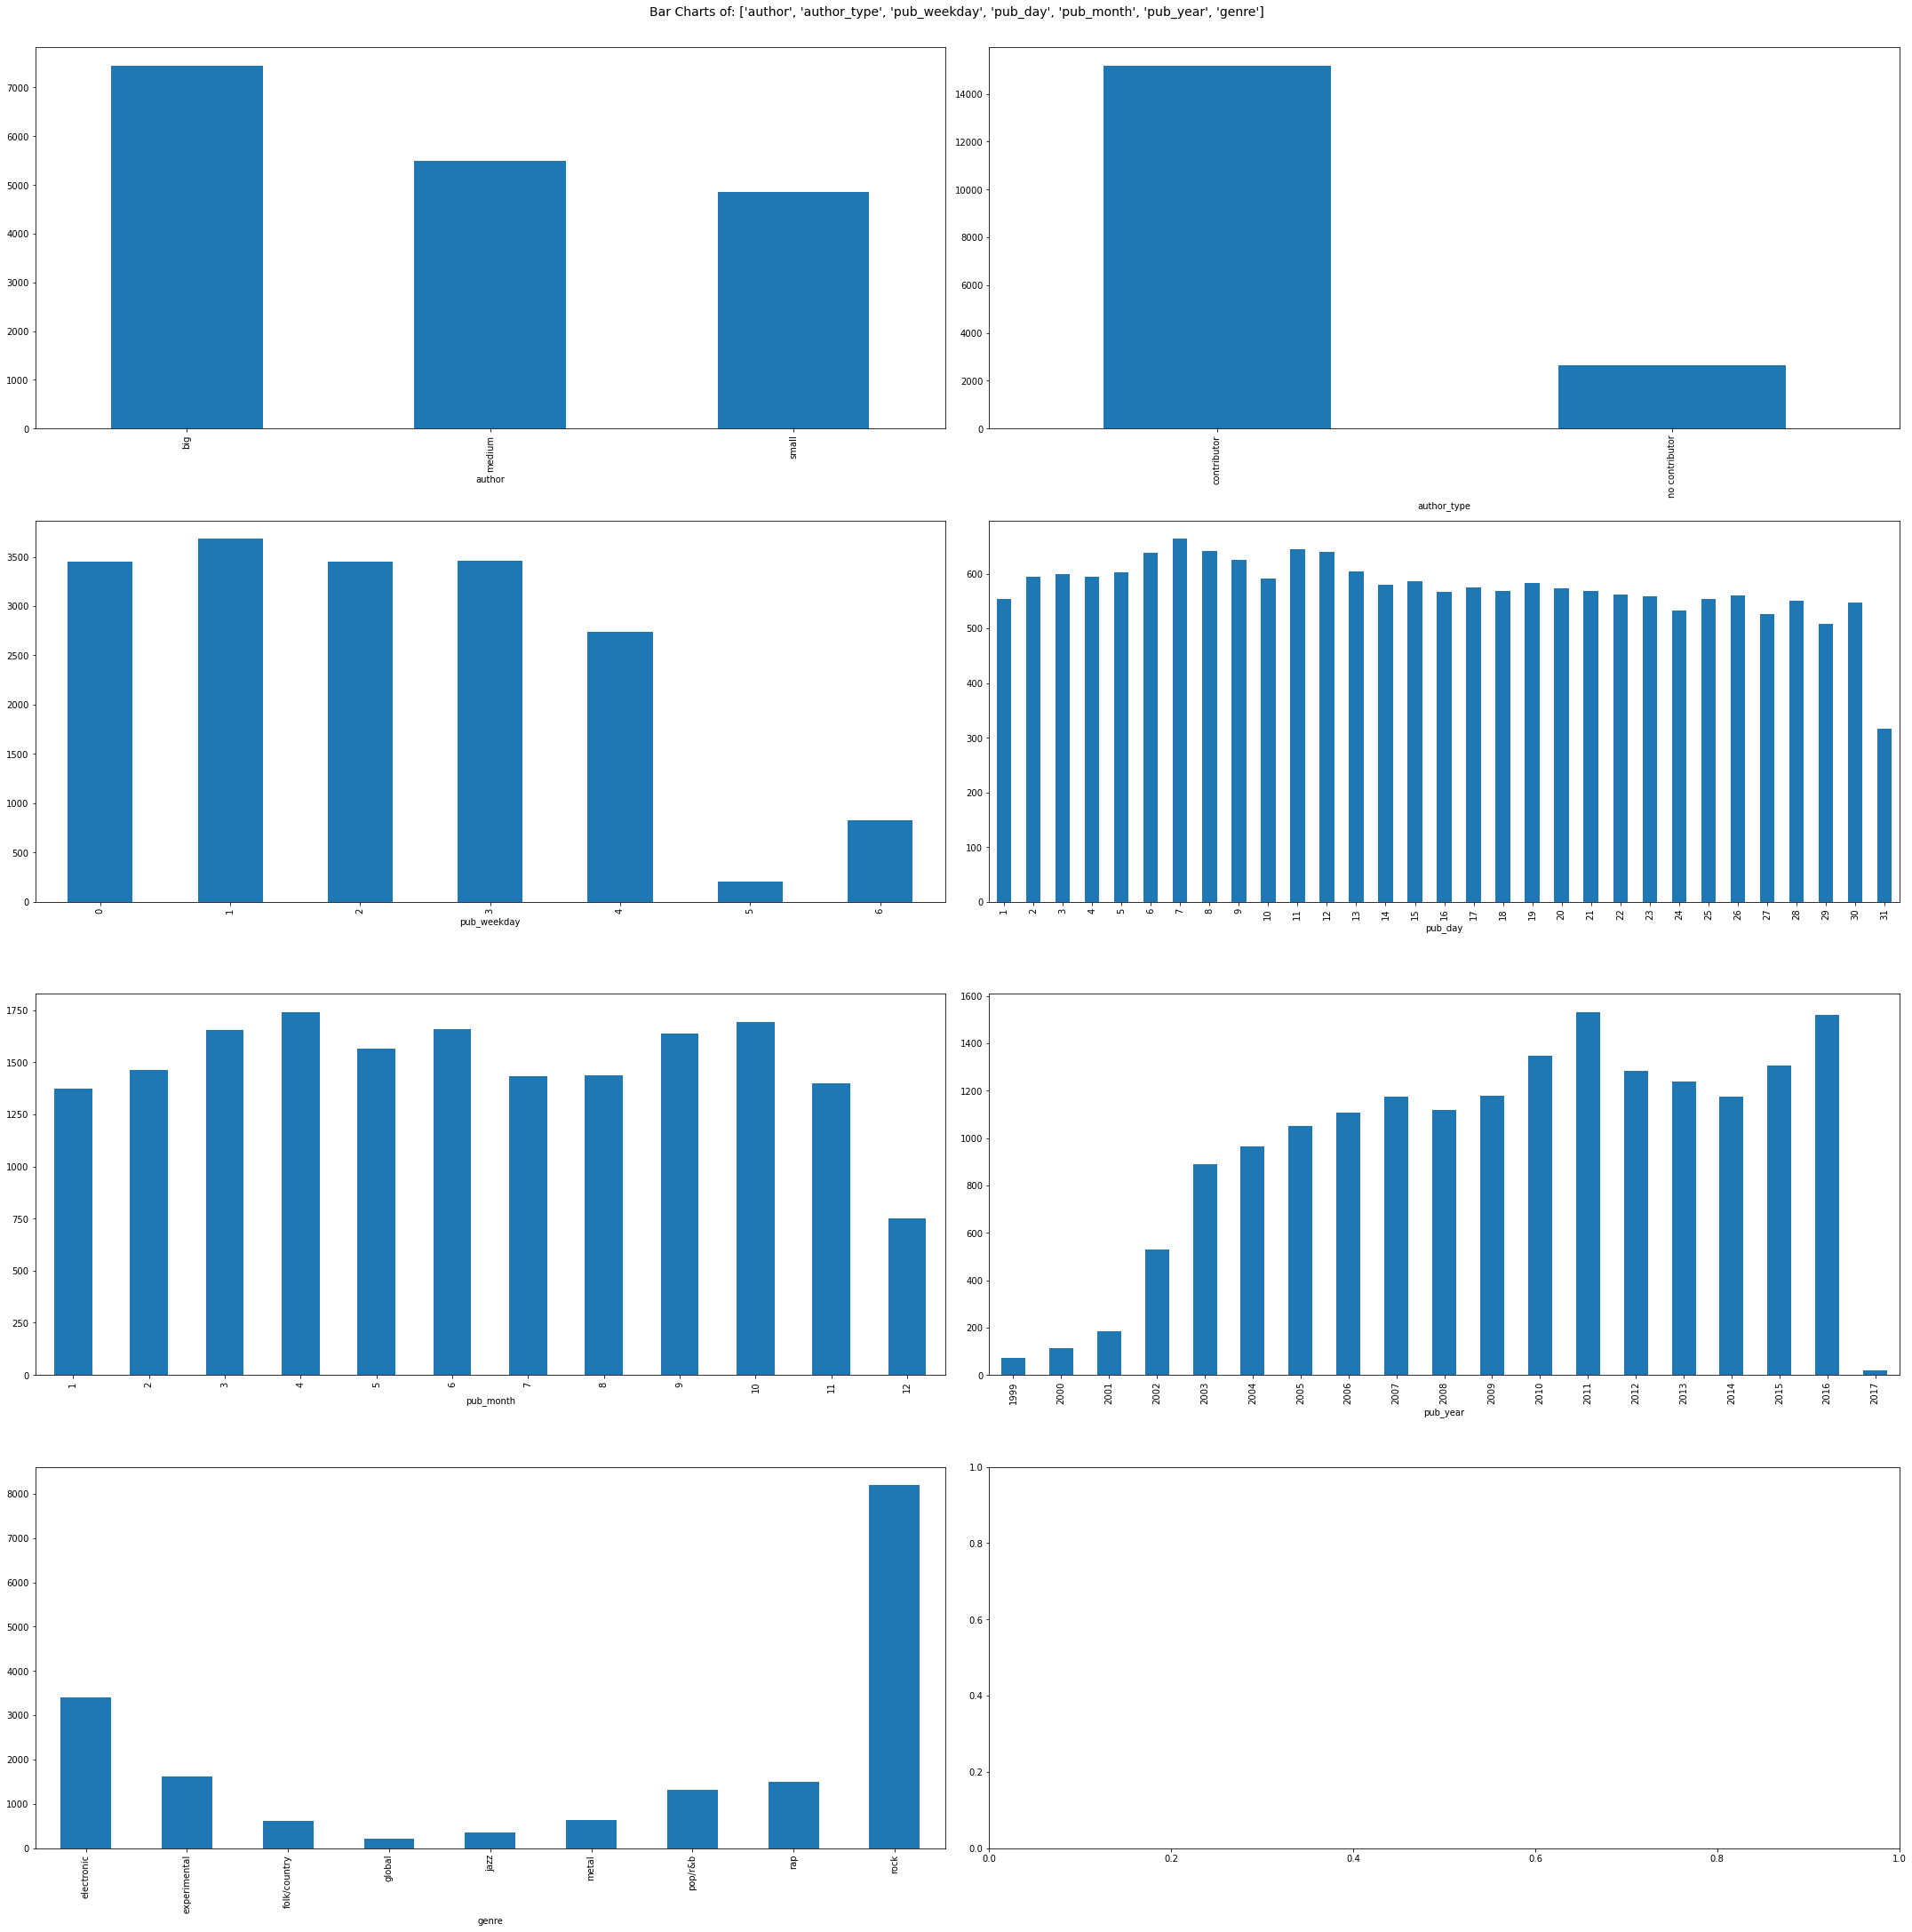

In [87]:
# after revision, display categorical features' distribution
plot_bar_charts(df_original, cat_cols, ncols=2, figsize=(30, 30))

All categorical variables look good!

#### 2) Numerical

In [88]:
def plot_histograms(data, cols_to_plot, ncols=4, bins=30, figsize=(10, 4), alpha=1e-3, show_normality_p=True):
    """
    Explore distribution of continuous (numerical) features
    """
    # just in case
    %matplotlib inline
    import matplotlib.pyplot as plt
    from scipy.stats import normaltest
    
    # generate plot
    nrows = (len(cols_to_plot)-1)//ncols + 1
    subplots = data.hist(cols_to_plot, bins=bins, layout=(nrows,ncols), figsize=figsize)
    if show_normality_p:
        selected, rejected = [], []
        if nrows > 1:
            for row in range(nrows):
                for col in range(ncols):
                    if ncols*row + col < len(cols_to_plot):
                        k2, p = normaltest(data[cols_to_plot[ncols*row + col]])
                        subplots[row][col].set_title(f"{subplots[row][col].get_title()} (p-value : {p:0.1g} ; $\\alpha$={alpha})")
                        if p < alpha: # null hypothesis: x comes from a normal distribution
                            rejected.append(cols_to_plot[ncols*row + col])
                        else: # pass the normality test
                            selected.append(cols_to_plot[ncols*row + col])
        else:
            for col in range(ncols):
                if col < len(cols_to_plot):
                    k2, p = normaltest(data[cols_to_plot[col]])
                    subplots[0][col].set_title(f"{subplots[0][col].get_title()} (p-value : {p:0.1g} ; $\\alpha$={alpha})")
                    if p < alpha: # null hypothesis: x comes from a normal distribution
                        rejected.append(cols_to_plot[col])
                    else: # pass the normality test
                        selected.append(cols_to_plot[col])

        print("normal columns:", selected)
        print("not normal columns:", rejected)
    
    plt.tight_layout();

normal columns: []
not normal columns: ['score', 'word_count', 'sentiment_score']


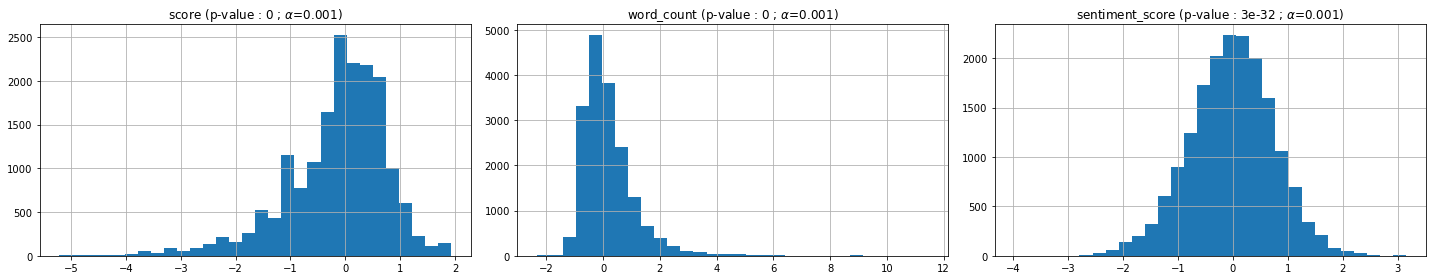

In [89]:
plot_histograms(df_original, num_cols, ncols=3, figsize=(20, 4), show_normality_p=True)

The ideal outcome for histogram is a bell curve or slightly skewed bell curve. If there is too much skewness, then outlier treatment should be done and the column should be re-examined, if that also does not solve the problem then only reject the column.

score is slightly left-skewed and word_count right-skewed. sentiment_score looks normaly distributed.
Since word_count is highly right-skewed, I will treat outliers:

In [90]:
# quick diagnosis on word_count
df_original[['word_count']].describe([0.25, 0.5, 0.75, 0.8, 0.85, .9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
word_count,17811.0,0.191172,0.955435,-2.340824,-0.430712,-0.007491,0.561798,0.737828,0.955056,1.273408,1.902622,3.808989,11.47191


In [91]:
df_original.query('word_count >= 3.8').shape[0] / df_original.shape[0]

0.010218404356858122

~1% is above 3.8 in `word_count` and we can consider them as outlier. Therefore, replace those above 3.8 with nearest value to 3.8 mark.

In [92]:
replace_val = df_original.query('word_count < 3.8')['word_count'].sort_values(ascending=False).iloc[0]
print(replace_val)

df_original.loc[df_original['word_count'] >= 3.8, 'word_count'] = replace_val

3.7865168539325844


normal columns: []
not normal columns: ['score', 'word_count', 'sentiment_score']


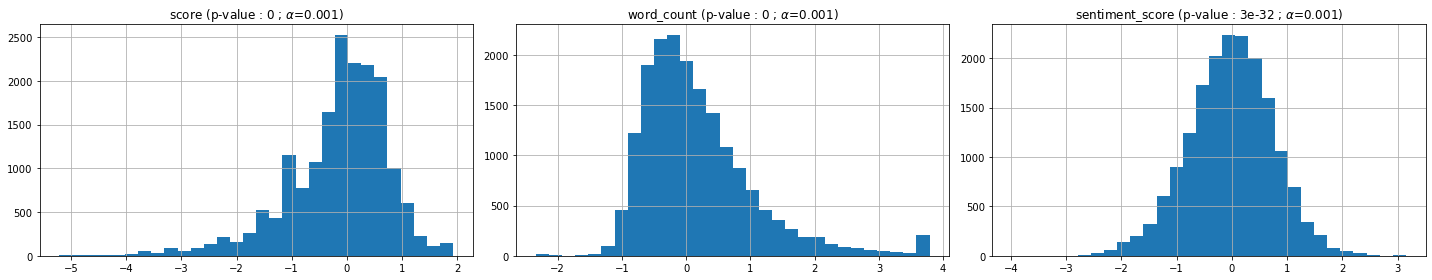

In [93]:
plot_histograms(df_original, num_cols, ncols=3, figsize=(20, 4), show_normality_p=True)

### Feature Selection

#### Numerical (features) vs Categorical (response)
#### Box Plot

In [94]:
def plot_box_plots(data, cols_to_plot, target=target, ncols=3, figsize=(20, 4)):
    """
    Explore Numerical vs. Categorical (between features and response)
    """

    # just in case
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    # Generating multiple subplots
    if len(cols_to_plot) > ncols:
        fig, subplot = plt.subplots(nrows=(len(cols_to_plot)-1)//ncols+1, ncols=ncols, figsize=figsize)
        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            tmp = data.boxplot(column=col_name, by=target, vert=True, ax=subplot[plot_number//ncols][plot_number%ncols])
            subplot[plot_number//ncols][plot_number%ncols].set_title(col_name)
    else: 
        fig, subplot = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            tmp = data.boxplot(column=col_name, by=target, vert=True, ax=subplot[plot_number])
            subplot[plot_number].set_title(col_name)
    

    plt.suptitle('Box plots of: ' + str(cols_to_plot), fontsize=14, y=1.01)
    
    plt.tight_layout();

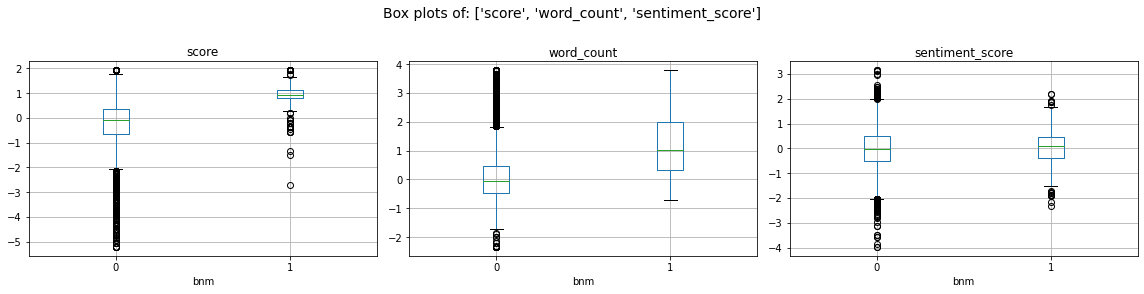

In [95]:
plot_box_plots(df_original, num_cols, target, ncols=3, figsize=(16, 4))

If the distribution looks similar for each category(Boxes are in the same line), that means the the numerical variable has 'NO EFFECT' (no predicting power) on the target variable. Hence, the variables are not correlated to each other.

On the other hand if the distribution is different for each category(the boxes are not in same line). It hints that these variables might be correlated with target (response).

sentiment_score looks suspicious. We will confirm the suspicion with ANOVA test below. 

#### ANOVA test

In [96]:
def anova_test(data, target=target, features=cat_cols, alpha = 0.05):
    """
    Study statistically Numerical vs. Categorical (between features and response)
    Analysis of variance(ANOVA) is performed to check if there is any relationship 
    between the given continuous and categorical variable. 
    
    H0: There is NO RELATIONSHIP between the given variables 
        (i.e. The average(mean) values of the numeric variable is same for all the 
        groups in the categorical variable)
        
    ANOVA Test result: Probability(p-value) of H0 being true
    """

    from scipy.stats import f_oneway
    
    # creating an empty list of final selected predictors
    selected = []
    print("##### ANOVA results #####")
    print("<probability of feature having NO RELATIONSHIP with response> \n")
    
    for feature in features:
        category_list = data.groupby(target)[feature].apply(list)
        anova_results = f_oneway(*category_list)
        
        # if the anova p-value is <0.05, then we reject H0
        if anova_results[1] < alpha:
            selected.append(feature)
        
        print(f"{feature}'s anova p-value is: {anova_results[1]:.2g}")
    print(f"\nselected features are {selected}")
    return selected

In [97]:
num_cols = anova_test(df_original, target, num_cols)

##### ANOVA results #####
<probability of feature having NO RELATIONSHIP with response> 

score's anova p-value is: 0
word_count's anova p-value is: 0
sentiment_score's anova p-value is: 0.0021

selected features are ['score', 'word_count', 'sentiment_score']


Despite my suspicion, sentiment_score passed ANOVA test!

#### Categorical (features) vs Categorical (response)
#### Grouped Bar Chart
When the target variable is categorical and the predictor is also categorical then we explore the correlation between them visually using barplots and statistically using Chi-square test.

In [98]:
# e.g., 
crosstab = pd.crosstab(index=df_original['author'], columns='bnm')
crosstab

col_0,bnm
author,
big,7451
medium,5498
small,4862


In [99]:
def plot_grouped_bar_charts(data, cols_to_plot, target, ncols=2, figsize=(14, 4)):
    """
    Explore Categorical (features) vs. Categorical (response)
    """

    # just in case
    %matplotlib inline
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Generating multiple subplots
    if len(cols_to_plot) > ncols:
        fig, subplot = plt.subplots(nrows=(len(cols_to_plot)-1)//ncols+1, ncols=ncols, figsize=figsize)
        plt.suptitle('Box plots of: ' + str(cols_to_plot), fontsize=14, y=1.0)

        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            crosstab = pd.crosstab(index=data[col_name], columns=data[target])
            crosstab.plot(kind='bar', color=['red', 'blue'], ax=subplot[plot_number//ncols][plot_number%ncols])
            subplot[plot_number//ncols][plot_number%ncols].set_title(col_name)
            subplot[plot_number//ncols][plot_number%ncols].set_xlabel('')
    else:
        fig, subplot = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
        plt.suptitle('Box plots of: ' + str(cols_to_plot), fontsize=14, y=1.0)

        # plotting
        for col_name, plot_number in zip(cols_to_plot, range(len(cols_to_plot))):
            crosstab = pd.crosstab(index=data[col_name], columns=data[target])
            crosstab.plot(kind='bar', color=['red', 'blue'], ax=subplot[plot_number])
            subplot[plot_number].set_title(col_name)
            subplot[plot_number].set_xlabel('')

    plt.tight_layout();

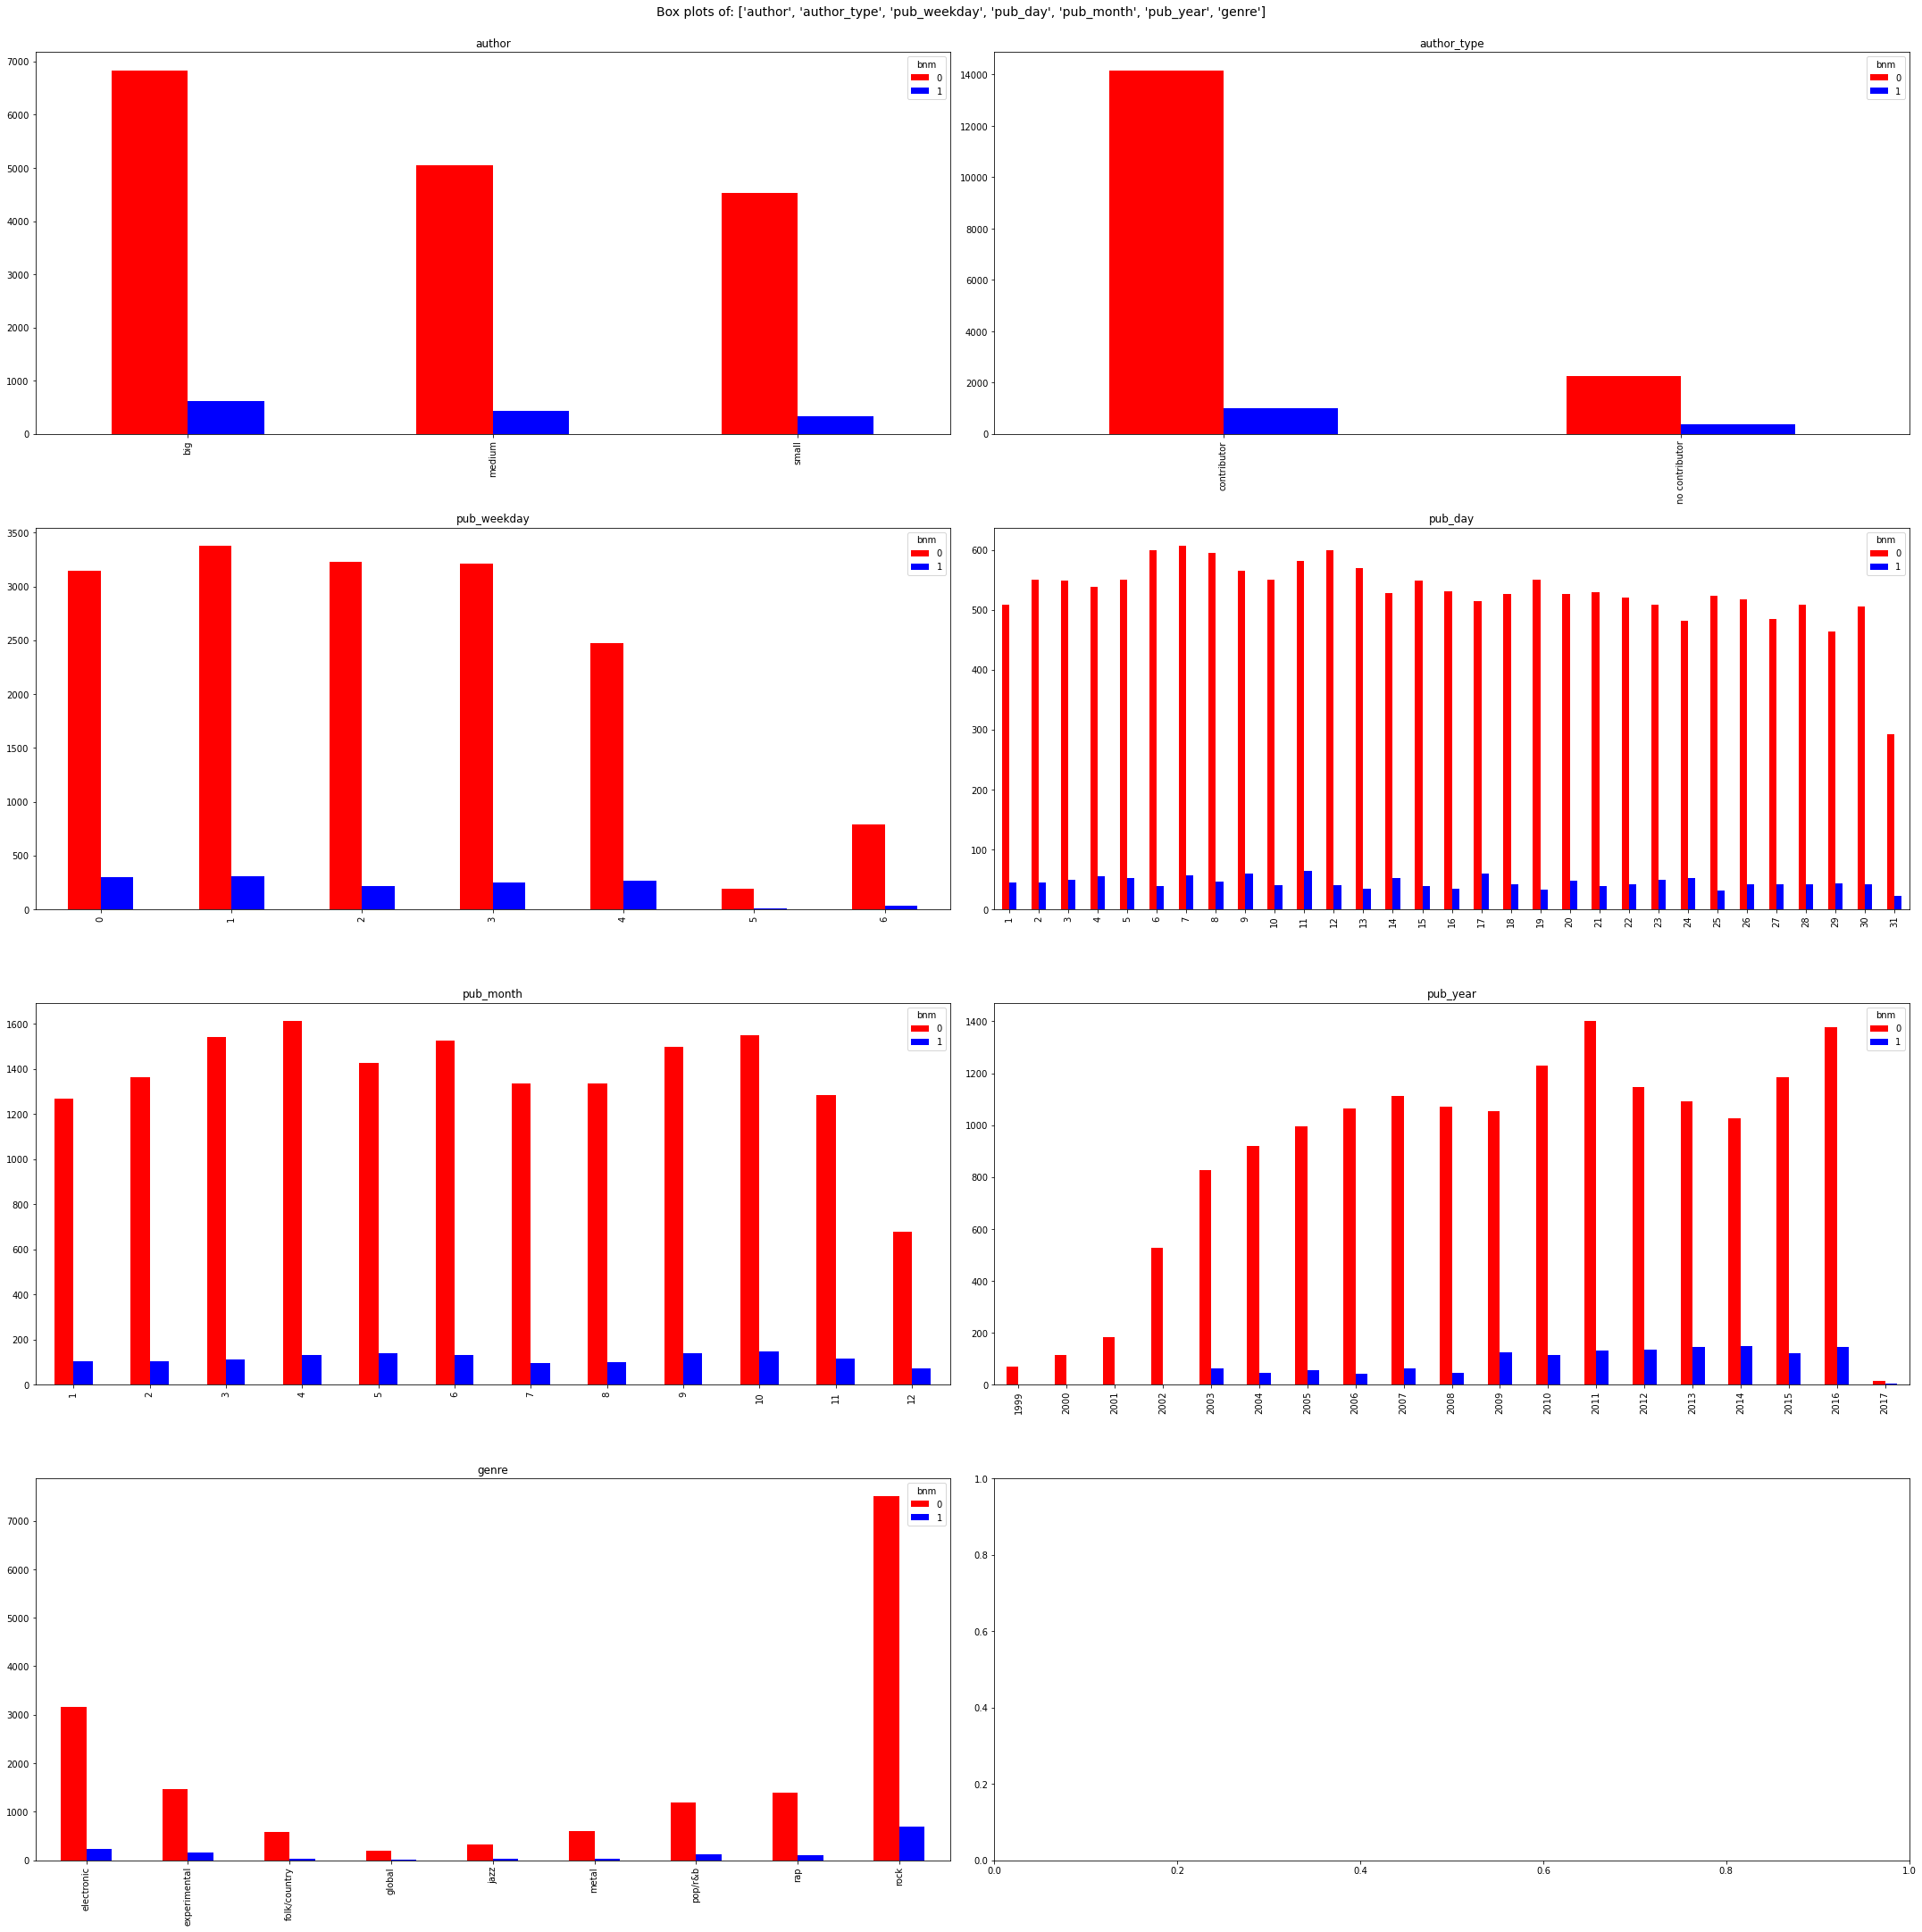

In [100]:
plot_grouped_bar_charts(df_original, cat_cols, target, figsize=(30, 30))

If the ratio of bars is similar across all categories, then the two columns (feature and response) are not correlated (i.e., independent). It is hard to see similar patters among features with the naked eye. It looks fine. We will see whether statistical test (chi-square test) agrees or not!

Looking at plots above, I'd like to address some thoughts:
- `pub_year`: No data of 1 before 2003 --> change categories to '<2004', '2004', ..., '2017'
- `pub_weekday`: It seems that best new musics are rarely released on weekdays (5: Sat, 6: Sun) --> combine them to -1(weekend)
- `genre`: some genres such as folk, country, global, jazz, and metal include very few best new music -> combine them to 'fringe'

#### `pub_year`

In [101]:
df_original = df_original.assign(pub_year = lambda x: x['pub_year'].astype(str))
# replace below 2004 with '<2004'
df_original.loc[df_original['pub_year'] < '2004', 'pub_year'] = '<2004'
df_original = df_original.assign(pub_year = lambda x: x['pub_year'].astype('category'))

#### `pub_weekday`

In [102]:
df_original = df_original.assign(pub_weekday = lambda x: x['pub_weekday'].astype(str))
# combine Saturday and Sunday into Weekend
df_original['pub_weekday'].replace({'5':'-1', '6':'-1'}, inplace=True)
df_original = df_original.assign(pub_weekday = lambda x: x['pub_weekday'].astype('category'))

#### `genre`

In [103]:
tmp = df_original.query('bnm==1').groupby('genre').size().to_frame('number')
tmp / tmp.sum() * 100

,number
genre,
electronic,16.678648
experimental,10.855500
folk/country,2.084831
global,0.718907
jazz,1.725377
metal,2.156722
pop/r&b,8.698778
rap,7.332854
rock,49.748382


Only a fraction is represented with 'folk/country', 'global', 'jazz', and 'metal'. I will combine them into 'fringe'

In [104]:
df_original = df_original.assign(genre = lambda x: x['genre'].astype(str))
# Conversion
df_original['genre'].replace({'folk/country':'fringe', 'global':'fringe'
                                    , 'jazz': 'fringe', 'metal': 'fringe'}, inplace=True)
df_original = df_original.assign(genre = lambda x: x['genre'].astype('category'))

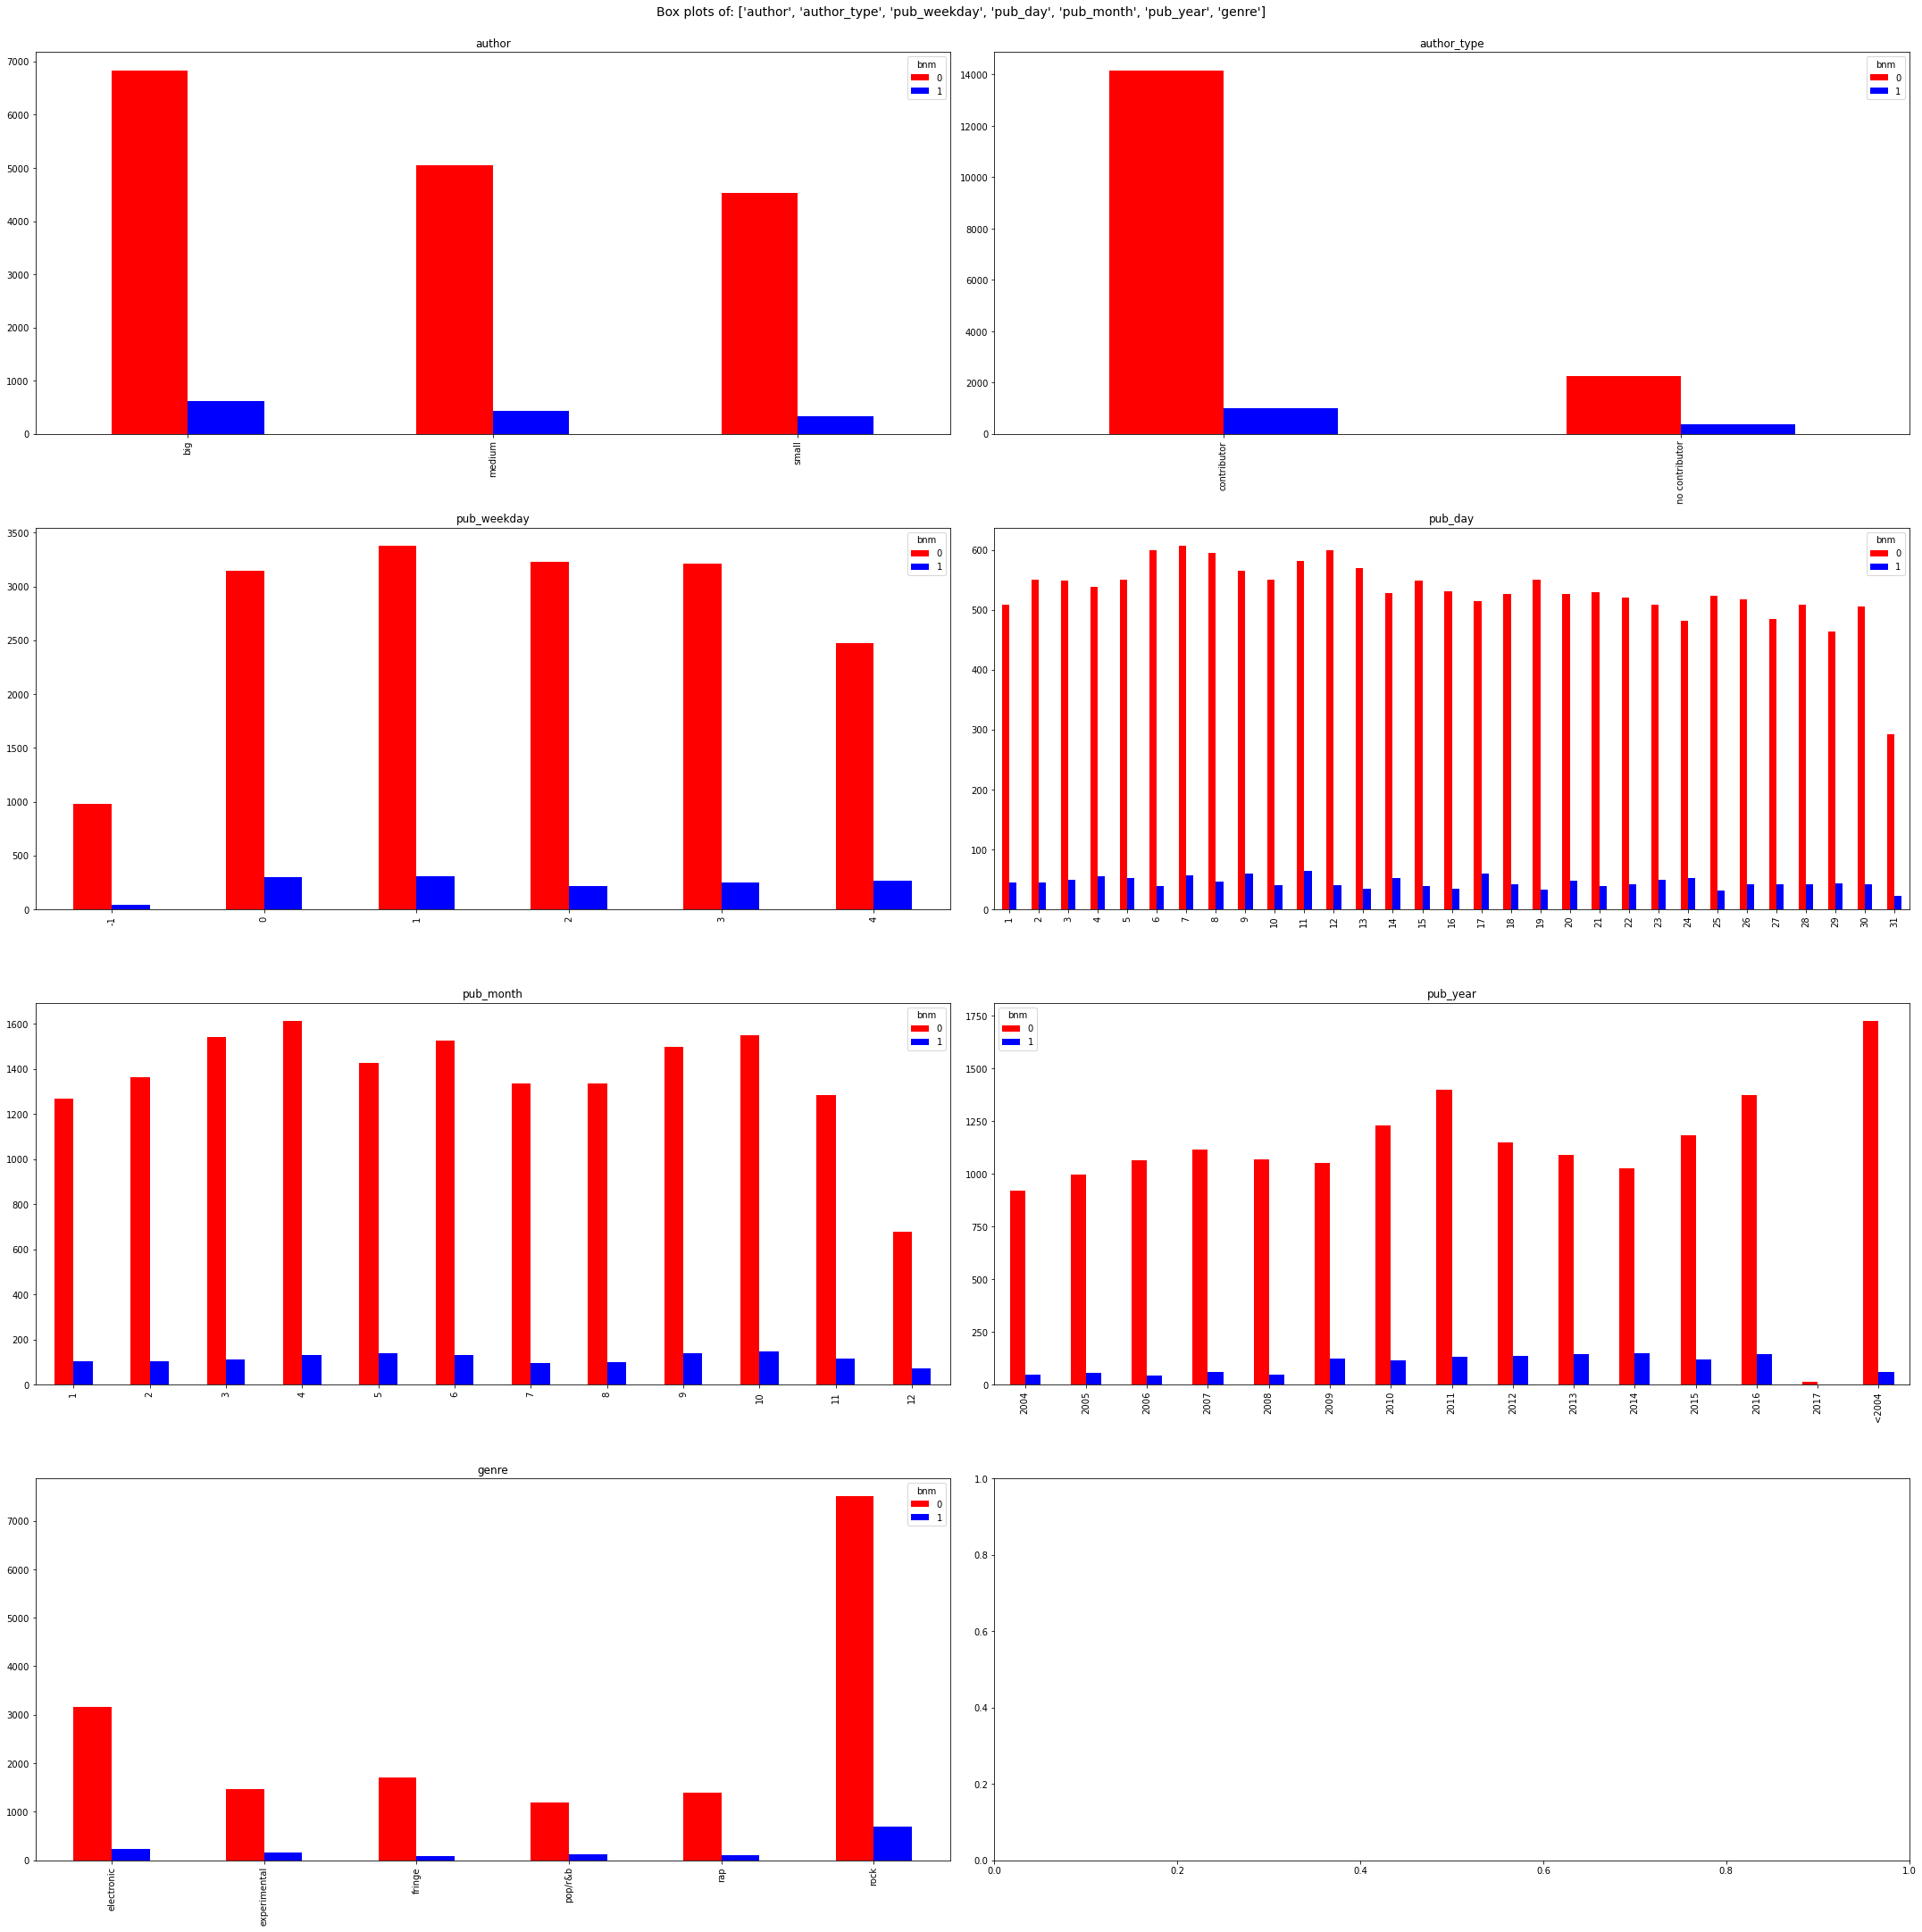

In [105]:
plot_grouped_bar_charts(df_original, cat_cols, target, figsize=(30, 30))

#### Chi-square test

In [106]:
def chi_square_test(data, target, features, alpha=0.05):
    """
    Study statistically Categorical (features) vs. Categorical (response)
    Chi-Square test is conducted to check the correlation 
    between two categorical variables (i.e., check independence)

    Assumption(H0): The two columns are NOT related to each other 
                    (i.e., independent of each other)
    Result of Chi-Sq Test: The Probability of H0 being True
    """

    from scipy.stats import chi2_contingency
    
    # create an empty list of final selected predictors
    selected = []
    print("##### Chi2 results ##### ")
    print("<probability of feature INDEPENDENT of response> \n")
    for feature in features:
        crosstab = pd.crosstab(index=data[feature], columns=data[target])
        chi_sq = chi2_contingency(crosstab)
        
        # If the chi_sq P-Value is <0.05, that means we reject H0
        if chi_sq[1] < alpha:
            selected.append(feature)
        
        print(f"{feature}'s chi-square p-value is: {chi_sq[1]:.2g}")
    print(f"\nselected features are {selected}")
    return selected

In [107]:
cat_cols = chi_square_test(df_original, target, cat_cols)

##### Chi2 results ##### 
<probability of feature INDEPENDENT of response> 

author's chi-square p-value is: 0.012
author_type's chi-square p-value is: 9.2e-42
pub_weekday's chi-square p-value is: 2.5e-09
pub_day's chi-square p-value is: 0.067
pub_month's chi-square p-value is: 0.13
pub_year's chi-square p-value is: 2.3e-41
genre's chi-square p-value is: 5.4e-07

selected features are ['author', 'author_type', 'pub_weekday', 'pub_year', 'genre']


`pub_day`, and `pub_month` did not pass the chi-square test; hence dropping them from features.

In [108]:
num_cols, cat_cols, target

(['score', 'word_count', 'sentiment_score'],
 ['author', 'author_type', 'pub_weekday', 'pub_year', 'genre'],
 'bnm')

In [109]:
df_original.drop(columns=['pub_day', 'pub_month'], inplace=True)
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17811 entries, 0 to 17810
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   score            17811 non-null  float64 
 1   bnm              17811 non-null  int64   
 2   author           17811 non-null  object  
 3   author_type      17811 non-null  category
 4   pub_weekday      17811 non-null  category
 5   pub_year         17811 non-null  category
 6   genre            17811 non-null  category
 7   word_count       17811 non-null  float64 
 8   sentiment_score  17811 non-null  float64 
dtypes: category(4), float64(3), int64(1), object(1)
memory usage: 766.7+ KB


-----

In [110]:
takeout = cat_cols
takeout

['author', 'author_type', 'pub_weekday', 'pub_year', 'genre']

In [111]:
takein = df_original.columns.drop(takeout+[target]).tolist()
takein

['score', 'word_count', 'sentiment_score']

In [112]:
formula = target + ' ~ ' + " + ".join(takein) 
formula += f' + C({takeout[0]}) + C({takeout[1]}) + C({takeout[2]}) + C({takeout[3]}) + C({takeout[4]})'
# display our formula
formula

'bnm ~ score + word_count + sentiment_score + C(author) + C(author_type) + C(pub_weekday) + C(pub_year) + C(genre)'

Now let's see how our logistic model fits!

In [113]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

model = smf.logit(formula=formula, data=df_original, missing='drop').fit(maxiter=1_000)
model.summary()

Optimization terminated successfully.
         Current function value: 0.131731
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    bnm   No. Observations:                17811
Model:                          Logit   Df Residuals:                    17780
Method:                           MLE   Df Model:                           30
Date:                Mon, 04 Oct 2021   Pseudo R-squ.:                  0.5194
Time:                        01:08:51   Log-Likelihood:                -2346.3
converged:                       True   LL-Null:                       -4882.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -7.2432      0.345    -21.010      0.000      -7.919      -6.567
C(author)[T.medium]                  0.0270      0.093      0.289      0.773      -0.156       0.210
C(author)[T.small]                  -0.1458      0.108     -1.349      0.177      -0.358       0.066
C(author_type)[T.no contributor]     0.5289      0.096      5.482      0.000       0.340       0.718
C(pub_weekday)[T.0]                  1.7093      0.256      6.679      0.000       1.208       2.211
C(pub_weekday)[T.1]                  1.6555      0.256      6.469      0.000       1.154       2.157
C(pub_weekday)[T.2]                  1.2517      0.260      4.815      0.000       0.742       1.761
C(pub_weekday)[T.3]                  1.5507      0.258      6.007      0.000       1.045       2.057
C(pub_weekday)[T.4]                  1.3809      0.261      5.289      0.000       0.869       1.893
C(pub_year)[T.2005]                  0.2989      0.266      1.124      0.261      -0.222       0.820
C(pub_year)[T.2006]                 -0.0948      0.280     -0.338      0.735      -0.644       0.454
C(pub_year)[T.2007]                  0.3877      0.260      1.489      0.137      -0.123       0.898
C(pub_year)[T.2008]                 -0.0426      0.278     -0.153      0.878      -0.587       0.502
C(pub_year)[T.2009]                  1.5994      0.250      6.393      0.000       1.109       2.090
C(pub_year)[T.2010]                  1.7441      0.243      7.182      0.000       1.268       2.220
C(pub_year)[T.2011]                  1.7021      0.236      7.197      0.000       1.239       2.166
C(pub_year)[T.2012]                  1.6828      0.241      6.983      0.000       1.211       2.155
C(pub_year)[T.2013]                  2.0477      0.240      8.546      0.000       1.578       2.517
C(pub_year)[T.2014]                  1.7989      0.242      7.423      0.000       1.324       2.274
C(pub_year)[T.2015]                  1.8884      0.246      7.677      0.000       1.406       2.371
C(pub_year)[T.2016]                  1.2209      0.245      4.978      0.000       0.740       1.702
C(pub_year)[T.2017]                  1.0826      1.010      1.072      0.284      -0.897       3.062
C(pub_year)[T.<2004]                -0.8323      0.258     -3.228      0.001      -1.338      -0.327
C(genre)[T.experimental]            -0.0980      0.143     -0.685      0.494      -0.378       0.182
C(genre)[T.fringe]                  -0.8160      0.161     -5.056      0.000      -1.132      -0.500
C(genre)[T.pop/r&b]                  0.0290      0.165      0.176      0.860      -0.294       0.352
C(genre)[T.rap]                     -0.2778      0.171     -1.620      0.105      -0.614       0.058
C(genre)[T.rock]                    -0.1969      0.106     -1.860      0.063      -0.405       0.011
score                                4.3030      0.121     35.448      0.000       4.065       4.541
word_coun

In [114]:
# # Save model and df_original
# # import pickle 

# df_original.to_pickle('df_original.pkl')

# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

### Model Evaluation

- Model has **converged**. 

- `Log-Likelihood`(LL(fit)): the log-likelihood of our fitted model (logistic regression)

- `LL-Null`(LL(null)): the log likelihood of the null model (a model with only an intercept)

- `Pseudo R2`: like linear regression, we need to find a measure of a good fit to compare to a measure of a bad fit. Unfortunately, the residuals for logistic regressions are all infinite, so we can't use them. But we can project the data onto the best fitting line and then we translate the log odd ratios/log odds back to probabilities and lastly, calculate the log-likelihood of the data given the best fitting curve. We can call this `LL(fit)`, for the log-likelihood of the fitted line and use `LL(fit)` as a substitute for SS(fit) (sum of squares for the residuals) in regular $R^2$ against worst value `LL(null)` and best possible value `LL(saturated)`. This metric enjoys the same [0, 1] range as regular $R^2$. In our case, **we have ~0.52 of pseudo-$R^2$ value meaning it is definetely better performing than with just intercept**. 

- `LLR p-value`: **P-value of 'null deviance - residual deviance'**. LLR is a chi-squared value with degrees of freedom euqual to the difference in the number of parameters in the fitted model and the null model. LLR p-value tells p-value for the log-likelihood of pseudo-$R^2$ which tells pseudo-$R^2$ is not by chance (when p-value is << 0.05). In our case, **p-value is very small close to 0 and it tells us that our pseudo-$R^2$ is statistically significant**.


Now let's see the quick performance check with accuracy and confusion matrix

In [115]:
threshold = 0.5 # this value might need experiment based on business objective
y_pred = pd.DataFrame(data=(model.predict(exog=df_original.drop(columns=target)) > threshold).astype(int)
             , columns=['prediction'])

y_test = df_original[[target]]
result = pd.concat([y_test, y_pred], axis=1)
result.head()

,bnm,prediction
0,0,1
1,0,0
2,0,0
3,0,0
4,1,1


In [116]:
# model accuracy
fit_acc = result.query('bnm == prediction').shape[0] * 100 / result.shape[0]
fit_acc

94.70551906125428

In [117]:
# default accuracy
tmp = df_original['bnm'].value_counts()
null_acc = tmp.iloc[0] * 100 / tmp.sum()
null_acc

92.19021952725844

In [118]:
(fit_acc - null_acc) / null_acc * 100

2.728380024360534

It seems better than choosing 'not best new music (0)' for all data (null model). The predicting power with regard to accuracy has increased by 2.73%. Given than it is highly imbalanced data, this cannot be said insignificant improvement. 

In [119]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
cfmt = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
                                                    , index=['true:1', 'true:0']
                                                    , columns=['pred:1', 'pred:0'])
print(cfmt)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     16420
           1       0.73      0.51      0.60      1391

    accuracy                           0.95     17811
   macro avg       0.85      0.75      0.79     17811
weighted avg       0.94      0.95      0.94     17811

        pred:1  pred:0
true:1     705     686
true:0     257   16163


As expected, due to the scarcity of 1 (best new music) data, the logistic model suffers in predicting 1 (best new music) - low precision, low recall, and low f1 score for 1. On the other hand, due to the pleathora of 0's (not best new music), it has very strong performance on 0 - high precision, high reccall and high f1 score. 

**For the better performance on classification, we need to collect more best new music data or take measures to mitigate imbalance case such as oversampling or undersampling. Also, if we put more emphasis on predicting 'best new music' correctly, we can try lowering threshold of probability to predict the music as 'best new music' at the cost of predicting 'not best new music' less correctly** 

### c) Calculate the odds ratios for your independent variables

To clarify the possible confusion, I should mention coefficients of independent variables can be interpreted as either **log odds** or **log odd ratios**. To elaborate, in case of numerical variable the coefficient means log odds; however in case of categorical variables, log odd ratios. In any way, I will stick to the term 'odd ratios' here.

> [Coefficient of cateogrical variables]
>
> When a logistic model is built using a categorical variable with N levels, it only considers N-1 levels, as the remaining level is used as a reference by the model. What this means to your model as a whole is that, each level (when remaining variables remain same) is compared to the reference level.
>
>For example, coef of categorical variables such as C(author_type)[no_contributor] means the log odd ratio of the odd that a author type is no_contributor over the odds that a athor type is contributor. 

**P-value tells if the coefficient is statistcally significant. But a small p-value alone isn't interesting. We also want large effect sizes and that's what the log(odds) and log(odds ratio) tells us.** Odds ratio is an unstandardized effect size statistic. It tells you the direction and the strength of the relationship between the independent variable and dependent variable.

,log_odd_ratio,odd_ratio,p-value,2.5%,97.5%
score,4.303038,73.924030,3.143071e-275,58.271660,93.780789
C(pub_year)[T.2013],2.047701,7.750061,1.270338e-17,4.845715,12.395166
C(pub_year)[T.2015],1.888429,6.608977,1.629596e-14,4.080835,10.703343
C(pub_year)[T.2014],1.798922,6.043130,1.148787e-13,3.758078,9.717580
C(pub_year)[T.2010],1.744107,5.720790,6.852032e-13,3.554323,9.207784
C(pub_weekday)[T.0],1.709257,5.524855,2.401470e-11,3.345755,9.123209
C(pub_year)[T.2011],1.702122,5.485576,6.141700e-13,3.450784,8.720208
C(pub_year)[T.2012],1.682804,5.380621,2.881694e-12,3.355181,8.628769
C(pub_weekday)[T.1],1.655547,5.235944,9.881491e-11,3.170641,8.646550
C(pub_year)[T.2009],1.599369,4.949910,1.627049e-10,3.031423,8.082543


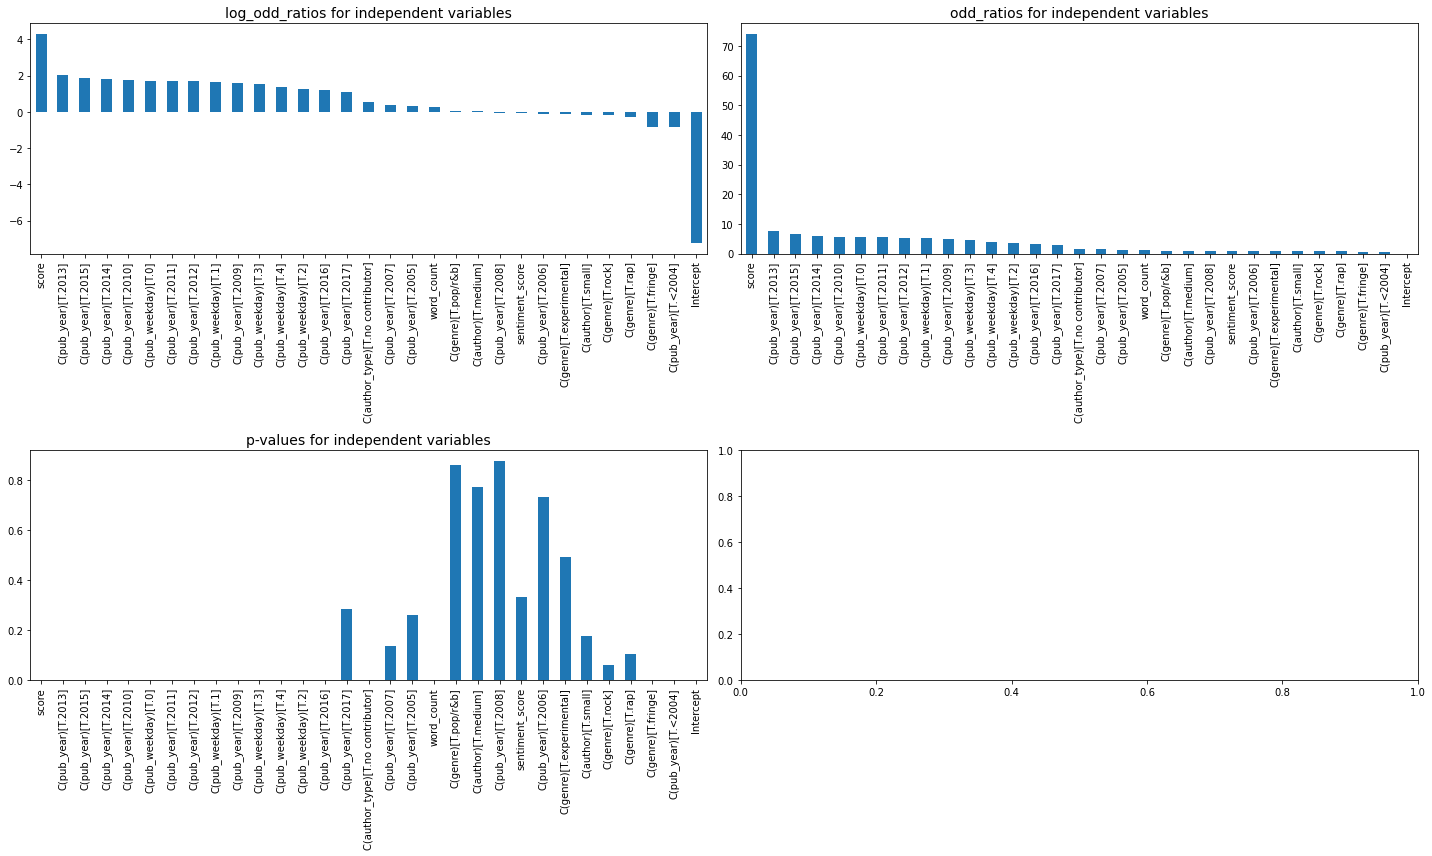

In [120]:
model_odds = pd.DataFrame({'log_odd_ratio':model.params, 'odd_ratio':np.exp(model.params)})
model_odds['p-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())

model_odds.sort_values(by=['odd_ratio'], ascending=False, inplace=True)

# # display log odd ratios & odd ratios visually
fig, subplot = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
for col_name, i in zip(['log_odd_ratio', 'odd_ratio', 'p-value'], range(3)):
    model_odds[col_name].plot(kind='bar', ax=subplot[i//2][i%2])
    subplot[i//2][i%2].set_title(f'{col_name}s for independent variables', fontsize=14)
plt.tight_layout();

# show odd ratios of features
model_odds

### d) What features are most/least predictive of a best new music designation and why do you think that is?

Let me write down my thoughts on features based on information we have just obtained right above:
- `score`: Very large positive effective size (log odd ratio:4.3 & odd ratio:73.7) and very very small p-value (statistically significant: 1.41e-276) (**good**)
- `word_count`: mild positive effective size(0.29 & 1.33) and very small p-value (1.10e-11) (**good**)
- `sentiment_score`: very small negative effective size (-0.055 & 0.95) and large p-value (0.332) (**bad**)
- `author`: small positive/negative effective size and very large p-value "in general" (**bad**)
- `author_type`: mild positive effective size and very small p-value (~1.39e-09) (**good**)
- `pub_weekday`:relatively large positive effective size and very small p-value (**good**)
- `pub_year`: relatively large positive effective size and small p-value "in general" (**good**)
- `genre`: mild negative effective size and large p-value "in general" (**bad**)

My verdict:
- **Most predictive feature**: `score` because it has significantly larger positive effective size (log odd ratio:4.3 and odd ratio:73.7) and virtually 0 p-value. 
- **Least predictive feature**: `sentiment_score` because it has small negative effective size (log odd ratio: -0.055 and odd ratio: 0.95) and large p-value (0.332). One might ask 'what about other bad ones like `author` or `genre`?'. I think they are week predictors due to the similar reason I just mentioned but what holds me back is they are "categorical" variables. If you consider how model is constructed, each categorical variables have a reference level and their contribution is absorved/included in `intercept`. Then, now, we see that `intercept` has very large negative effective size and virtually 0 of p-value. Therefore, all things considered, I believe `sentiment_score` has the least predicting power. 

> note: reference [this part](#Binary-fitted-line-plots) for further evidence.

### e) If you were to engineer an additional feature for the regression, what would it be? Describe how you would approach constructing that feature.

While conducting `4) feature engineering` section, we touched on text base features, such as `word_count` and `sentiment_score`. If I were to engineer additional features, I'd like to implement the following features:

1. `character count` of review 
2. average `word density` of review
3. `punctuation count` of review
4. `uppercase count` of review
5. `title word count` of review
6. `noun count` of review
7. `verb count` of review
8. `adjective count` of review
9. `pronoun count` of review
10. `TF-IDF vectors` based on review


Below is a possible way of constructing aformentioned features:

```python
import string
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

## 1. Character count 
df_original['char_count'] = df_original['content'].apply(len)

## 2. Average word density
df_original['word_density'] = df_original['char_count'] / (df_original['word_count']+1) # to prevent dividing by 0

## 3. Pounctuation Count
df_original['punctuation_count'] = df_original['content'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

## 4. Uppercase word count
df_original['uppercase_count'] = df_original['content'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

## 5. Title word count
df_original['title_count'] = df_original['content'].apply(lambda x: len([word for word in x.split() if word.istitle()]))

## Frequency distribution of POS (6, 7, 8, 9)
## group pos
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS']
    , 'pron' : ['PRP','PRP$','WP','WP$']
    , 'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ']
    , 'adj' :  ['JJ','JJR','JJS']
    , 'adv' : ['RB','RBR','RBS','WRB']
    }
                
def check_pos_tag(x):
    noun, verb, adj, adv, pron = 0, 0, 0, 0, 0
    
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family['noun']:
                noun += 1
            elif ppo in pos_family['verb']:
                verb += 1
            elif ppo in pos_family['adj']:
                adj += 1
            elif ppo in pos_family['adv']:
                adv += 1
            elif ppo in pos_family['pron']:
                pron += 1
    except:
        pass
                
    return [noun, verb, adj, adv, pron]
                
## initialize columns
df_original['noun_count'] = 0
df_original['verb_count'] = 0
df_original['adj_count'] = 0
df_original['adv_count'] = 0
df_original['pron_count'] = 0

## insert pos into proper columns
count_holder = df_original['content'].map(check_pos_tag)
df_original.loc[:, 'noun_count'] = count_holder.map(lambda x: x[0])
df_original.loc[:, 'verb_count'] = count_holder.map(lambda x: x[1])
df_original['adj_count'] = count_holder.map(lambda x: x[2])
df_original['adv_count'] = count_holder.map(lambda x: x[3])
df_original['pron_count'] = count_holder.map(lambda x: x[4])

## 10. TF-IDF vectors (word level; 1-gram)
PUNCTUATION = str.maketrans('', '', string.punctuation)
DIGITS = str.maketrans('', '', string.digits)

def preprocess_text(text):    
    ## convert to lowercase, remove punctuation & remove numbers
    text = text.lower().translate(PUNCTUATION).translate(DIGITS)
    ## lemmatize words & remove extra spaces
    text = " ".join([Word(word).lemmatize("v") for word in TextBlob(text).words])
    
    return text
                
## filter out stop words of English, and too frequently used words are out, 
## (for example) less than 10 times (< 0.001%) used words are out
## Only take top 2,000 frequent terms
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), 
                             min_df=10, max_df=0.70, max_features=2_000, stop_words='english')
tfidf = vectorizer.fit_transform(df_original['content'].values.astype('U'))
                
```



## 6) Data Visualization (Optional): 

Using the results from your regression and data analysis create a visualization that tells a story about the data. Feel free to take personal liberties with this and be as creative as you like. 

### Residual base plots

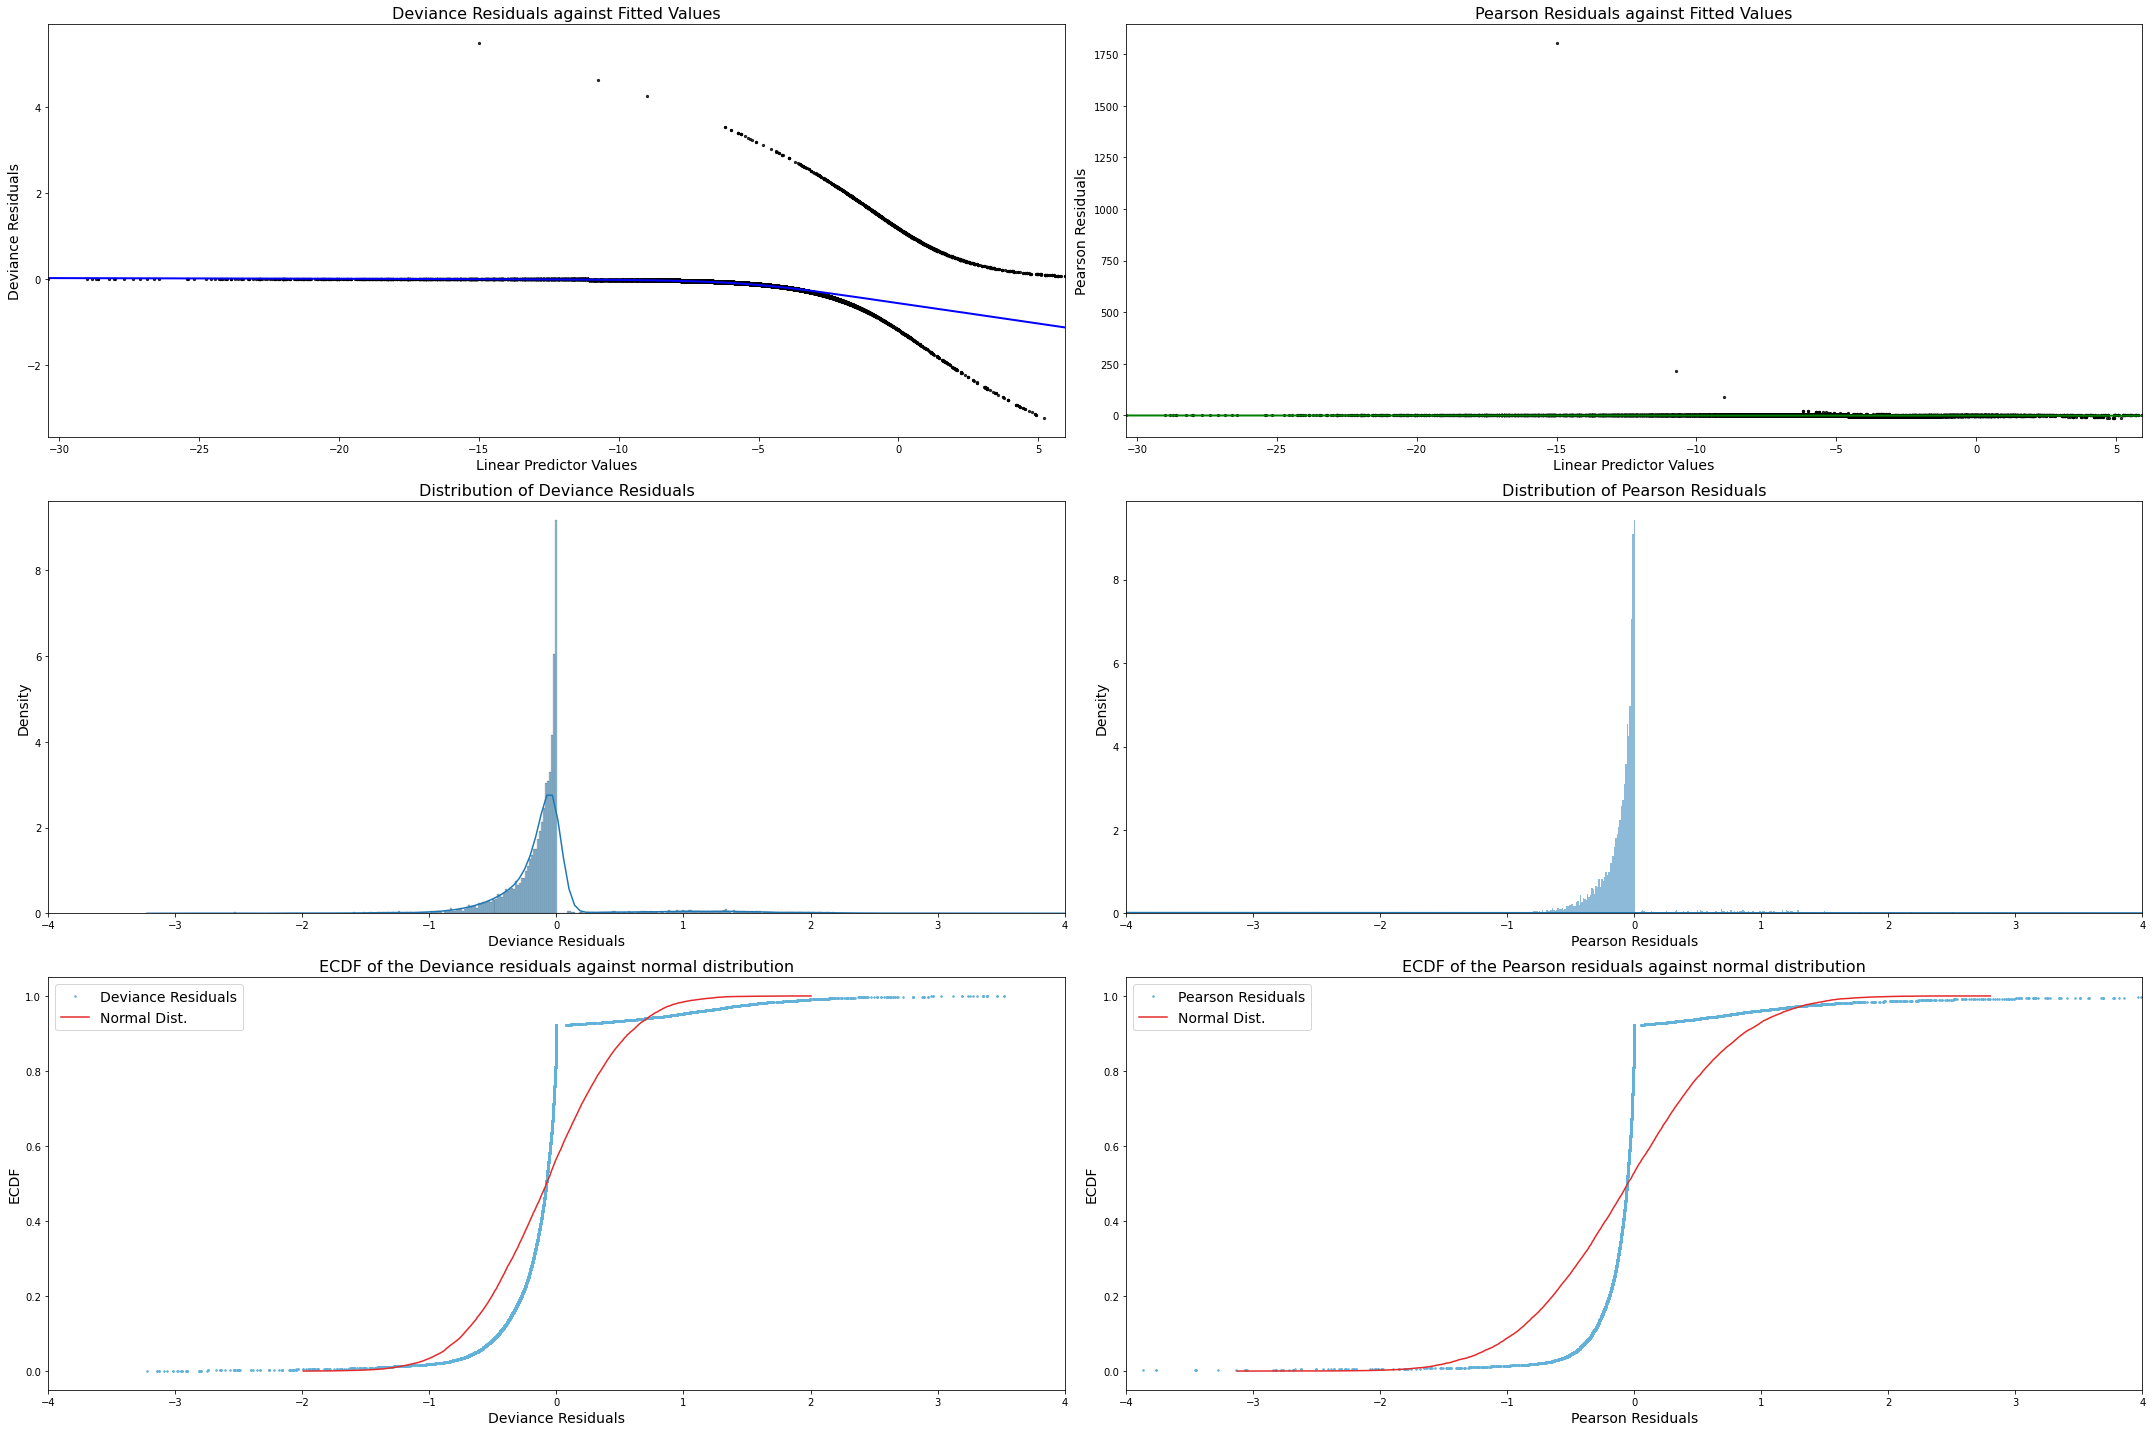

In [123]:
# running this cell would take ~5 min

# define a helper function
def ecdf(obs):
    """
    Compute ECDF(Empirical Cumulative Distribution Function) for a 1-d array of measurements.   
    INPUT:  obs: observations of 1d array or list
    Output:  1) x: sorted 1d array
             2) y: cumulative probability of same order as x
    """
    
    ## numbber of data points
    n = len(obs)
    ## x-axis: random variable 
    x = np.sort(obs)
    ## y-axis: fraction of data or cumulative probability
    y = np.arange(1, n+1) / n
    
    return x, y

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

# 1) residual plots
###### Deviance Residuals
sns.regplot(model.fittedvalues, model.resid_dev, ax=ax[0][0],
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

ax[0][0].set_title("Deviance Residuals against Fitted Values", fontsize=16)
ax[0][0].set_xlabel("Linear Predictor Values", fontsize=14)
ax[0][0].set_ylabel("Deviance Residuals", fontsize=14)

###### Pearson Residuals
sns.regplot(model.fittedvalues, model.resid_pearson, ax=ax[0][1],
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

ax[0][1].set_title("Pearson Residuals against Fitted Values", fontsize=16)
ax[0][1].set_xlabel("Linear Predictor Values", fontsize=14)
ax[0][1].set_ylabel("Pearson Residuals", fontsize=14)


# 2) Distributions of Residuals
###### Deviance Residuals
sns.histplot(model.resid_dev, kde=True, stat='density', ax=ax[1][0])
ax[1][0].set_xlabel('Deviance Residuals', fontsize=14)
ax[1][0].set_ylabel('Density', fontsize=14)
ax[1][0].set_title ('Distribution of Deviance Residuals', fontsize=16)
ax[1][0].set_xlim(-4, 4) #(0%, 99.99%)

###### Pearson Residuals
sns.histplot(model.resid_pearson, kde=True, stat='density', ax=ax[1][1])
ax[1][1].set_xlabel('Pearson Residuals', fontsize=14)
ax[1][1].set_ylabel('Density', fontsize=14)
ax[1][1].set_title ('Distribution of Pearson Residuals', fontsize=16)
ax[1][1].set_xlim(-4, 4) # (0.27%, 99.6%)


# 3) Normal Probability Plots
###### Deviance Residuals
# perfectly normally ditributed residuals for reference
normal_dr = np.random.normal(model.resid_dev.mean(), model.resid_dev.std(), df_original.shape[0])

# call ecdf function
sample_x, sample_y = ecdf(model.resid_dev)
normal_x, normal_y = ecdf(normal_dr)

ax[2][0].plot(sample_x, sample_y, marker='.', markersize=3, linestyle='none', color='#61B1D8')
ax[2][0].plot(normal_x, normal_y, color='#E52929')

ax[2][0].legend(['Deviance Residuals', 'Normal Dist.'], loc='best', fontsize=14)
ax[2][0].set_title('ECDF of the Deviance residuals against normal distribution', fontsize=16)
ax[2][0].set_ylabel('ECDF', fontsize=14)
ax[2][0].set_xlabel('Deviance Residuals', fontsize=14)
ax[2][0].set_xlim(-4, 4); #(0%, 99.99%)

###### Pearson Residuals
# perfectly normally ditributed residuals for reference
truncated_pearson_residual = model.resid_pearson.loc[model.resid_pearson.between(-13.4, 13.4)] #from min to 99.9%
normal_pr = np.random.normal(truncated_pearson_residual.mean(), truncated_pearson_residual.std(), df_original.shape[0])

# call ecdf function
sample_x, sample_y = ecdf(model.resid_pearson)
normal_x, normal_y = ecdf(normal_pr)

ax[2][1].plot(sample_x, sample_y, marker='.', markersize=3, linestyle='none', color='#61B1D8')
ax[2][1].plot(normal_x, normal_y, color='#E52929')

ax[2][1].legend(['Pearson Residuals', 'Normal Dist.'], loc='best', fontsize=14)
ax[2][1].set_title('ECDF of the Pearson residuals against normal distribution', fontsize=16)
ax[2][1].set_ylabel('ECDF', fontsize=14)
ax[2][1].set_xlabel('Pearson Residuals', fontsize=14)
ax[2][1].set_xlim(-4, 4); # (0.27%, 99.6%)

plt.tight_layout();

The diviance residuals represent the square root of the contribution that each data point has to the overall residual deviance. Therefore, deviance residuals are analogous to the residuals in ordinary least squares. When we square the deviance residuals, we get the residual deviance that we use to assess how well a model fits the data. Also, we use diviance residuals to identify outliers.
$$
\begin{align*}
\text{Residual Devidance} &= 2[LL(saturated) - LL(fit)] \\
                          &= \sum_{x\in \text{all data points}}(\sqrt{2\times[Log(saturated(x)) - Log(fitted(x)) \ ]}\ \ )^2 \\
                          &= \sum(\sqrt{\text{devidance residuals}} \ )^2
\end{align*}
$$

On Pearsons residuals,
The Pearson residual is the difference between the observed and estimated probabilities divided by the binomial standard deviation of the estimated probability; therefore standardizing the residuals. This is one of the most direct way of handling the non-constant variance by dividing out:
$$
\begin{align*}
\text{Pearson Residual} &= \frac{y_i - \pi_i}{\sqrt{Var(\pi_i)|_{\pi_i}}} \quad \text{where} \ y_i: \text{observed value},\ \pi_i: \text{predicted value}
\end{align*}
$$

If devidance residuals or pearson residual stay close to 0, it means the logistic regression model is adequate or correct. The reason we use these metrics is unlike linear regerssion we cannot assess residuals without transformation in order for them to be useful. Usually either the (Studentized) pearson residuals or the deviance residuals are used to assess the fitness of a model to data. 

----
### Plot interpretation:
- `First row`: Both residual plots  are **pretty flat close to 0 which implies our model is adequate and correct**. 
- `Second row`: We see kind of the left half of normal distribution around 0. It is because almost always saturated model predicts better than fitted model (w.r.t. devidance residual) and our target values are 0 mostly therefore $y_i-\pi_i$ is negative (w.r.t. pearson residual). However, we confirm that **our model is adequate by looking at high peak at 0 in both residual distribution plots**. 
- `Third row`: In both normal probability plots, we see that **our residuals are more crowded around 0 (mean)** (therfore higher slope) than it is supposed to be if it were following normal distribution with residuals' mean and standard deviation. Therefore, actually it is a good news - **our model is adequate**!
----

### Binary fitted line plots

We can even display binary fitted line plot aginst an independent variable combined. Below is one possible way of showing these plots:

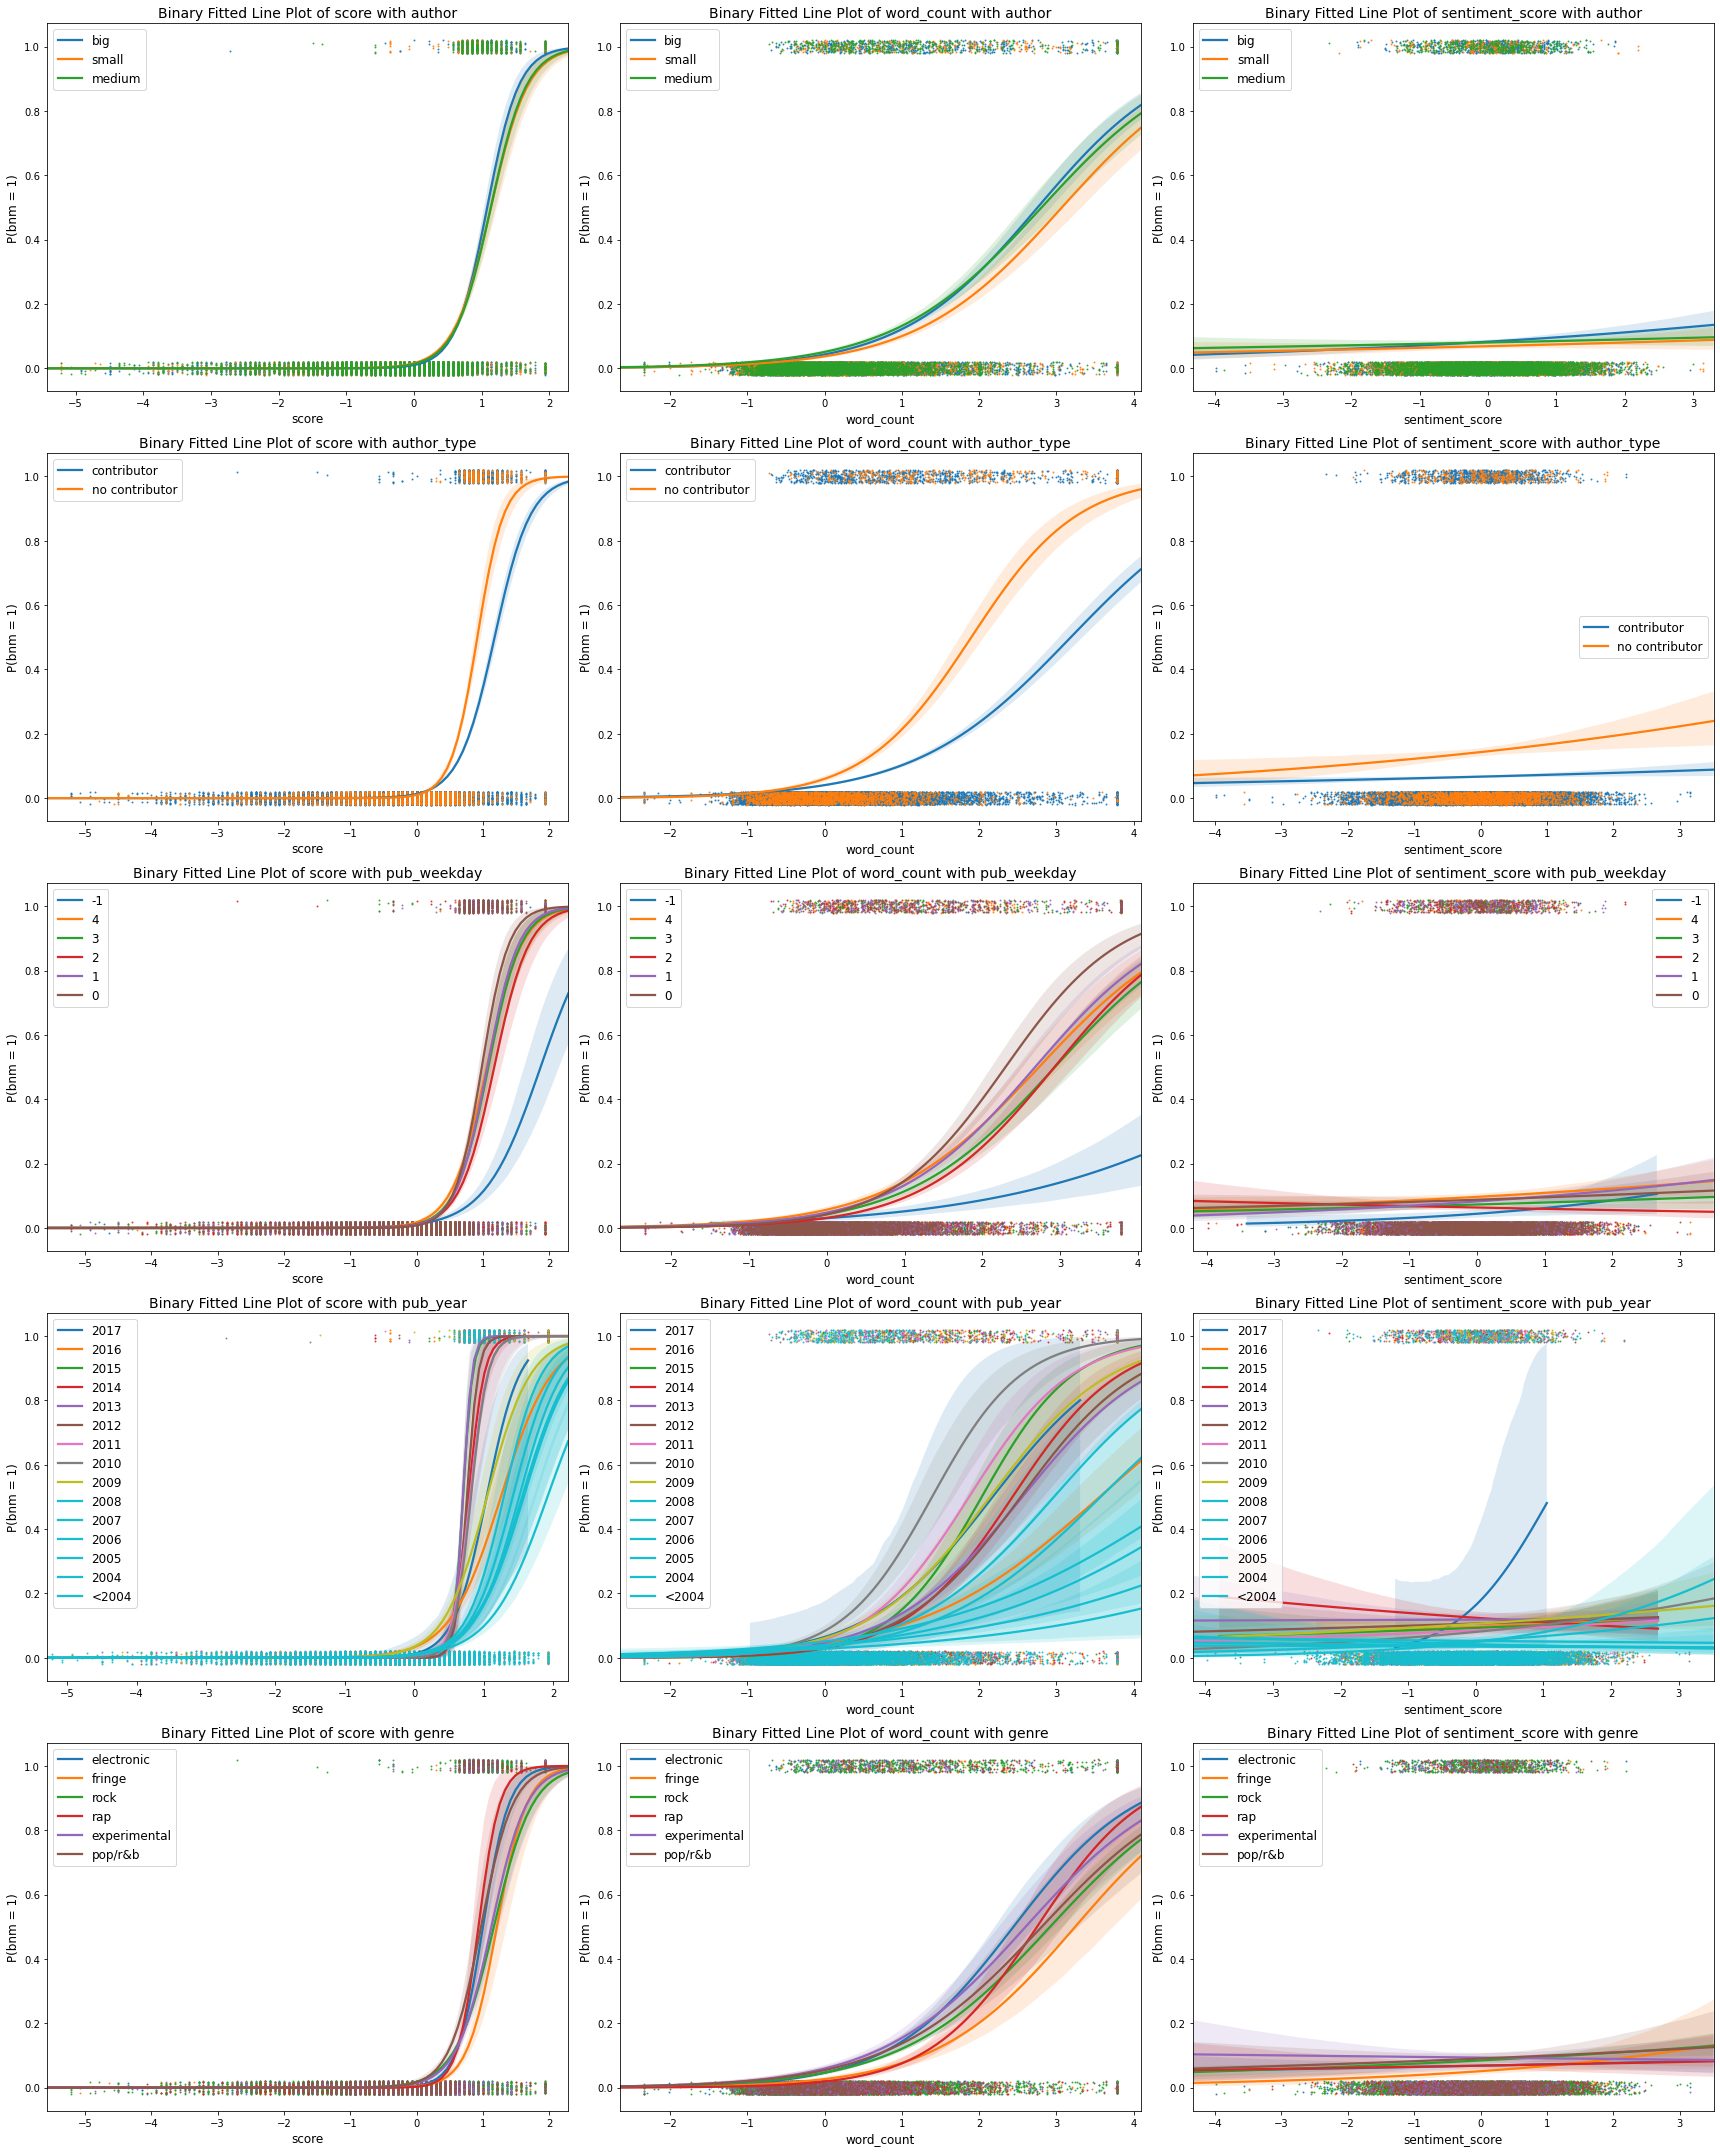

In [124]:
# running this cell takes ~10 min

# define a helper function to plot binary fitted line plots
def hue_regplot(data, x, y, hue, palette=None, ax=None, **kwargs):
    """ 
    Display seaborn regplot in conjunction with 'hue' (categorical variable)
    """
    from matplotlib.cm import get_cmap
    
    regplots = []
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x, y=y, data=data[data[hue] == key], logistic=True, y_jitter=.02
                , color=palette[key], truncate=False, ax=ax
                , scatter_kws={'s':1, 'marker':'.'}
                , **kwargs)
        )
        
    if ax:
        ax.set_xlabel(x, fontsize=12)
        ax.set_ylabel(f"P({y} = 1)", fontsize=12)
        ax.set_title(f"Binary Fitted Line Plot of {x} with {hue}", fontsize=14)
        ax.legend(levels, loc='best', fontsize=12)

    return regplots


fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(24, 30))

# Recall: 
# numerical features - score, word_count, sentiment_score
# categorical features - author, author_type, pub_weekday, pub_year, genre

# score with author
hue_regplot(data=df_original, x='score', y='bnm', hue='author', ax=ax[0][0])
# score with author_type
hue_regplot(data=df_original, x='score', y='bnm', hue='author_type', ax=ax[1][0])
# score with pub_weekday
hue_regplot(data=df_original, x='score', y='bnm', hue='pub_weekday', ax=ax[2][0])
# score with pub_year
hue_regplot(data=df_original, x='score', y='bnm', hue='pub_year', ax=ax[3][0])
# score with genre
hue_regplot(data=df_original, x='score', y='bnm', hue='genre', ax=ax[4][0])


# word_count with author
hue_regplot(data=df_original, x='word_count', y='bnm', hue='author', ax=ax[0][1])
# word_count with author_type
hue_regplot(data=df_original, x='word_count', y='bnm', hue='author_type', ax=ax[1][1])
# word_count with pub_weekday
hue_regplot(data=df_original, x='word_count', y='bnm', hue='pub_weekday', ax=ax[2][1])
# word_count with pub_year
hue_regplot(data=df_original, x='word_count', y='bnm', hue='pub_year', ax=ax[3][1])
# word_count with genre
hue_regplot(data=df_original, x='word_count', y='bnm', hue='genre', ax=ax[4][1])


# sentiment_score with author
hue_regplot(data=df_original, x='sentiment_score', y='bnm', hue='author', ax=ax[0][2])
# sentiment_score with author_type
hue_regplot(data=df_original, x='sentiment_score', y='bnm', hue='author_type', ax=ax[1][2])
# sentiment_score with pub_weekday
hue_regplot(data=df_original, x='sentiment_score', y='bnm', hue='pub_weekday', ax=ax[2][2])
# sentiment_score with pub_year
hue_regplot(data=df_original, x='sentiment_score', y='bnm', hue='pub_year', ax=ax[3][2])
# sentiment_score with genre
hue_regplot(data=df_original, x='sentiment_score', y='bnm', hue='genre', ax=ax[4][2])

plt.tight_layout();

We can use the fitted line plot to examine the relationship between the response(bnm) and the independent variables. In general, the steeper the slope is, the better predictor the independent variable used is. 

The plots above gives me confidence that indeed **`score` is a strong predictor** for predicting best new music regardless of categorical variables it is in conjunction with - it shows steep slopes. Also, **`sentiment_score`** that I considered the least predictive feature seems indeed **a weak predictor** because it shows very low slope regardless which categorical variable it is in conjunction with indicating it has very small predicting power. 


### Conclusion of the secion 6) Data Visualization
Through residual related plots and fitted line plot aganst individual (numerical) features, I could gain more confidence in the conclusions I made in the previous section about best/least predictive features and model's adequacy/correctness. 